# Time-Temperature Water Mastercurve

Auto-TTS on time-temp water oscillatory sweeps.

**Data:** examples/data/pyRheo/time-temp-water/ttw_*_*.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.models.herschel_bulkley import HerschelBulkley
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import arviz as az


INFO:2025-12-06 19:58:23,503:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load multi-temperature sweeps

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'time-temp-water'
files = [p for p in DATA_DIR.glob('ttw_*_*.csv') if p.is_file()]

datasets = []
for fpath in sorted(files):
    parts = fpath.stem.split('_')
    temp_c = float(parts[1])
    df = pd.read_csv(fpath)
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df['Angular Frequency'] = pd.to_numeric(df['Angular Frequency'], errors='coerce')
    df['Storage Modulus'] = pd.to_numeric(df['Storage Modulus'], errors='coerce')
    df['Loss Modulus'] = pd.to_numeric(df['Loss Modulus'], errors='coerce')
    df = df.dropna()
    omega = df['Angular Frequency'].to_numpy()
    Gp = df['Storage Modulus'].to_numpy()
    Gpp = df['Loss Modulus'].to_numpy()
    datasets.append(RheoData(x=omega, y=Gp + 1j*Gpp, x_units='rad/s', y_units='Pa', domain='oscillation', metadata={'temperature': temp_c + 273.15}))

mc = Mastercurve(reference_temp=298.15, method='wlf', auto_shift=True)
master, shifts = mc.create_mastercurve(datasets, return_shifts=True)
print(f"Temps (C): {[round(d.metadata['temperature']-273.15,1) for d in datasets]}")


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 3.420413s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1252 | final_cost=1.005028e-04 | time=3.420s | final_gradient_norm=0.007251767518970865


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.523327s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1267 | final_cost=7.315456e-05 | time=2.523s | final_gradient_norm=0.006310429558402864


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.398399s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1255 | final_cost=1.320568e-04 | time=2.398s | final_gradient_norm=0.008538177595948092


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.588298s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1308 | final_cost=6.064903e-05 | time=2.588s | final_gradient_norm=0.30814766161398094


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.584707s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=751 | final_cost=5.010735e-04 | time=1.585s | final_gradient_norm=0.010154740740319574


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.686088s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=817 | final_cost=2.754774e-04 | time=1.686s | final_gradient_norm=0.008096812091738693


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.490543s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=651 | final_cost=6.474603e-04 | time=1.491s | final_gradient_norm=2.018641451300891


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.596126s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=691 | final_cost=6.473377e-04 | time=1.596s | final_gradient_norm=40.94054060656885


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.428166s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=681 | final_cost=6.380344e-04 | time=1.428s | final_gradient_norm=0.5215847612634149


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.404550s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=659 | final_cost=5.715928e-04 | time=1.405s | final_gradient_norm=1.013604692103007


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.388697s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=93 | final_cost=2.350862e-04 | time=0.389s | final_gradient_norm=0.017428473402252523


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.870528s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=908 | final_cost=2.215488e-04 | time=1.871s | final_gradient_norm=0.39856216239560405


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.396842s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=657 | final_cost=5.707327e-04 | time=1.397s | final_gradient_norm=0.40739212172876194


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.340292s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=623 | final_cost=5.694603e-04 | time=1.340s | final_gradient_norm=0.4561131151193062


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.300233s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=65 | final_cost=3.128697e-04 | time=0.300s | final_gradient_norm=0.00022683302584751577


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.284480s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=63 | final_cost=3.127569e-04 | time=0.284s | final_gradient_norm=5.7051737160233835e-05


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.816985s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=954 | final_cost=5.755286e-04 | time=1.817s | final_gradient_norm=0.10753859987115626


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.744134s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=850 | final_cost=3.007907e-04 | time=1.744s | final_gradient_norm=0.01995309482722051


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.896348s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=951 | final_cost=3.257798e-04 | time=1.896s | final_gradient_norm=0.1118927436623495


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.772728s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=861 | final_cost=2.593163e-04 | time=1.773s | final_gradient_norm=0.014530727826460343


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.967772s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=964 | final_cost=3.175652e-04 | time=1.968s | final_gradient_norm=0.2584616339863477


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.930027s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=942 | final_cost=3.173863e-04 | time=1.930s | final_gradient_norm=0.0104634992368039


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.150062s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1035 | final_cost=1.650887e-04 | time=2.150s | final_gradient_norm=0.004839004352861976


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.070455s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1013 | final_cost=1.537305e-04 | time=2.070s | final_gradient_norm=0.00528488241477517


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.885847s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=927 | final_cost=9.929661e-05 | time=1.886s | final_gradient_norm=0.0064580686482788


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.891109s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=921 | final_cost=7.889665e-05 | time=1.891s | final_gradient_norm=0.007410462887506789


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.216575s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=28 | final_cost=6.257285e-05 | time=0.217s | final_gradient_norm=3.482055805487306e-05


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.366767s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=108 | final_cost=5.336247e-05 | time=0.367s | final_gradient_norm=0.6452123536507448


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.943024s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=998 | final_cost=4.078985e-04 | time=1.943s | final_gradient_norm=0.038587186612444965


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.605346s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=778 | final_cost=4.065538e-04 | time=1.605s | final_gradient_norm=0.017322529511965775


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.238242s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=37 | final_cost=3.639621e-04 | time=0.238s | final_gradient_norm=8.153180130330928e-07


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.223134s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=28 | final_cost=3.620399e-04 | time=0.223s | final_gradient_norm=0.01823519007604298


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.349471s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1170 | final_cost=4.951001e-04 | time=2.349s | final_gradient_norm=0.015320160115081357


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.030737s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1054 | final_cost=4.821643e-04 | time=2.031s | final_gradient_norm=0.033612204979346985


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.030882s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1053 | final_cost=2.123763e-04 | time=2.031s | final_gradient_norm=0.05410019500028971


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.726563s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1484 | final_cost=3.486054e-05 | time=2.727s | final_gradient_norm=0.03526660515717509


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.212795s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=22 | final_cost=3.387986e-04 | time=0.213s | final_gradient_norm=0.000492442373986199


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.213673s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=22 | final_cost=2.997412e-04 | time=0.214s | final_gradient_norm=4.280037601382941e-05


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 3.236966s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1671 | final_cost=1.480330e-04 | time=3.237s | final_gradient_norm=0.008180904057570089


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 3.097146s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1573 | final_cost=1.257570e-04 | time=3.097s | final_gradient_norm=0.016234675014021982


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.247391s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1222 | final_cost=2.683607e-04 | time=2.247s | final_gradient_norm=0.04575117164809914


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.774444s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=875 | final_cost=2.369519e-04 | time=1.774s | final_gradient_norm=0.023449069822161835


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.723007s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=846 | final_cost=4.639247e-04 | time=1.723s | final_gradient_norm=0.017219378435018688


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.911828s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=925 | final_cost=1.738802e-04 | time=1.912s | final_gradient_norm=0.015876663378453296


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.426301s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1220 | final_cost=1.683591e-04 | time=2.426s | final_gradient_norm=0.007030826659714836


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.502991s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1264 | final_cost=1.446726e-04 | time=2.503s | final_gradient_norm=0.047356328287100305


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.177532s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=1.322180e-03 | time=0.178s | final_gradient_norm=0.00036016999302856836


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.187935s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=8.392862e-04 | time=0.188s | final_gradient_norm=0.0009601934691620223


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.173899s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=1.828364e-03 | time=0.174s | final_gradient_norm=0.00033526108373405566


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.180581s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=7.768045e-04 | time=0.181s | final_gradient_norm=2.3026937171076135e-05


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.174440s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=7.338565e-04 | time=0.174s | final_gradient_norm=0.005731785508302066


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.182054s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=9 | final_cost=4.019186e-04 | time=0.182s | final_gradient_norm=6.418400083367461e-07


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.272002s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=49 | final_cost=3.399393e-04 | time=0.272s | final_gradient_norm=0.0010303669018386181


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.219638s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=28 | final_cost=3.225811e-04 | time=0.220s | final_gradient_norm=3.1364246685663004e-07


Temps (C): [70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 85.0, 85.0, 85.0, 85.0, 85.0, 90.0, 90.0, 90.0, 90.0, 90.0, 95.0, 95.0, 95.0, 95.0]


## Plot raw vs shifted

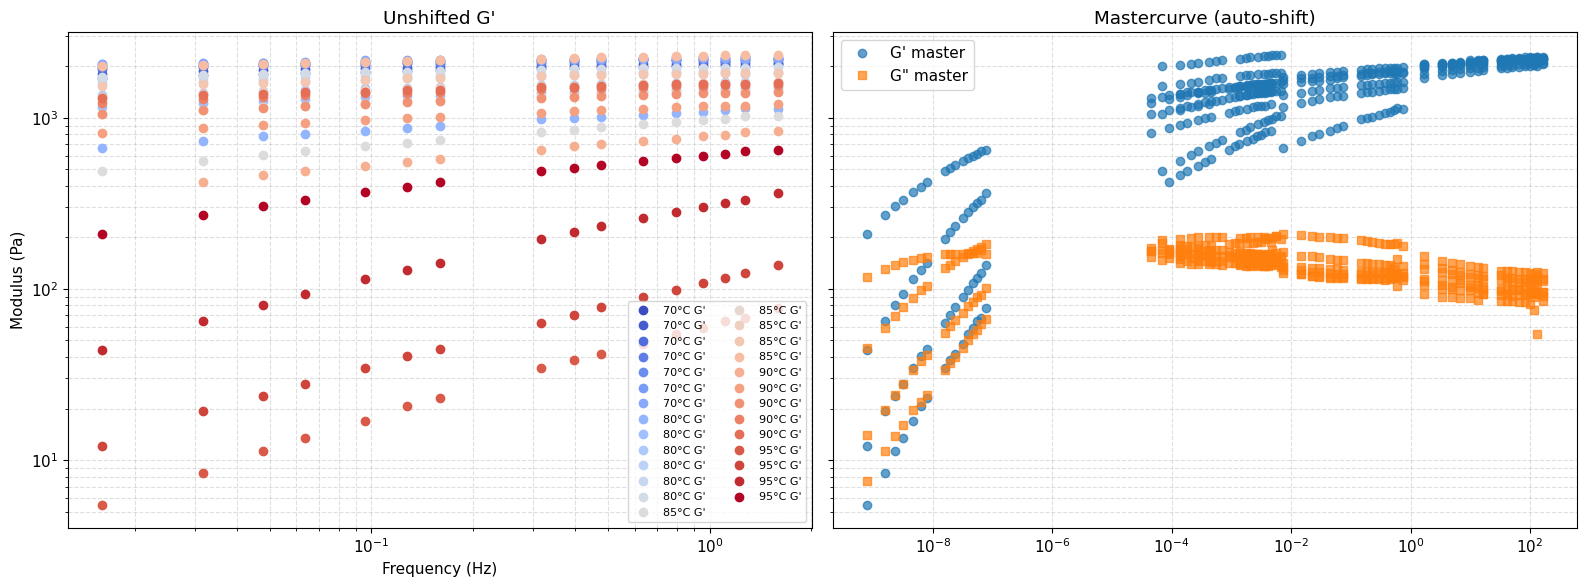

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
colors = plt.cm.coolwarm(np.linspace(0, 1, len(datasets)))
for c, data in zip(colors, datasets):
    temp_c = data.metadata['temperature'] - 273.15
    axes[0].loglog(data.x/(2*np.pi), np.real(data.y), 'o', color=c, label=f"{temp_c:.0f}°C G'")
axes[0].set_title("Unshifted G'")
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Modulus (Pa)')
axes[0].grid(True, which='both', ls='--', alpha=0.4)
axes[0].legend(ncol=2, fontsize=8)

axes[1].loglog(master.x/(2*np.pi), np.real(master.y), 'o', label="G' master", alpha=0.7)
axes[1].loglog(master.x/(2*np.pi), np.imag(master.y), 's', label='G" master', alpha=0.7)
axes[1].set_title('Mastercurve (auto-shift)')
axes[1].grid(True, which='both', ls='--', alpha=0.4)
axes[1].legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Fit models on mastercurve

In [5]:
omega_master = master.x
G_master = master.y

gm = GeneralizedMaxwell(n_modes=5, modulus_type='tensile')
gm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega_master)
gm_pred = gm_pred_components[:,0] + 1j*gm_pred_components[:,1]
gm_r2 = r2_complex(G_master, gm_pred)

fm_pred = np.full_like(G_master, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega_master, test_mode='oscillation')
    fm_r2 = r2_complex(G_master, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})

Auto-enabling multi-start optimization for very wide range (11.3 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.632102s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=2.145900e+07 | time=0.632s | final_gradient_norm=19411829.06980979


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.281681s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=2.145900e+07 | time=0.282s | final_gradient_norm=19411829.06980979


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.698106s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=2.162708e+07 | time=0.698s | final_gradient_norm=56869665220.91165


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.726850s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=2.208761e+07 | time=0.727s | final_gradient_norm=5895916388.419473


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.569224s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=17 | final_cost=2.499365e+07 | time=0.569s | final_gradient_norm=5233685948.190708


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.300571s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=79 | final_cost=4.294400e+07 | time=0.301s | final_gradient_norm=3209986.609154658


Element minimization: early termination at n_modes=1 (R²=0.842971 < threshold=0.882300)


Element minimization: reducing from 5 to 2 modes


Auto-enabling multi-start optimization for very wide range (11.3 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.013282s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=54 | final_cost=4.692491e+01 | time=1.013s | final_gradient_norm=16.797543698782054


{'gm_r2': 0.7422342012487237, 'fm_r2': -5462057598.434477}


## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.463083s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=3.469342e+03 | time=0.463s | final_gradient_norm=3.107338749993338


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.244439s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=3.469342e+03 | time=0.244s | final_gradient_norm=3.107338749993338


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.187561s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=3.790934e+04 | time=0.188s | final_gradient_norm=84442771.23833059


Element minimization: early termination at n_modes=1 (R²=0.930405 < threshold=0.990446)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.328632s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=47 | final_cost=1.222337e-03 | time=0.329s | final_gradient_norm=0.00015236830486870095


Model ranking (R²): [('gm', 0.977), ('fm', -94.83)]


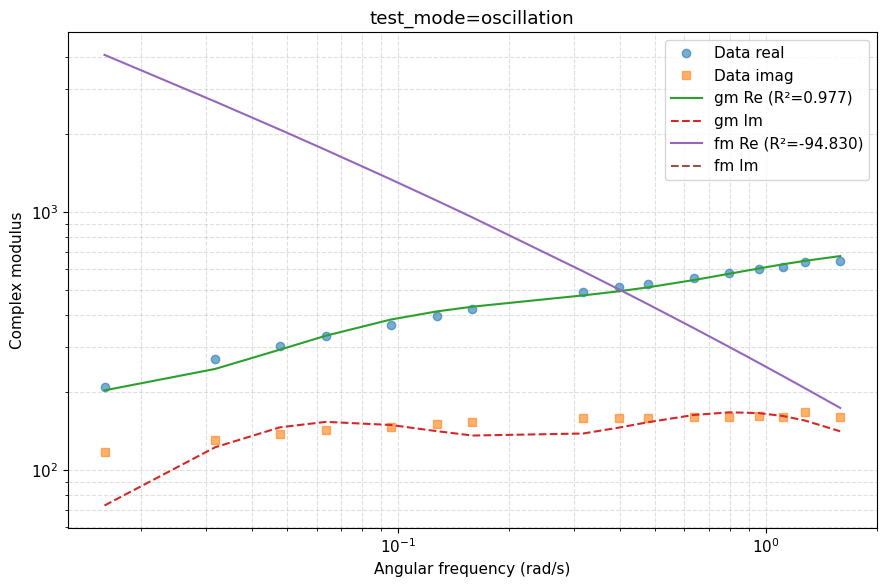

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<46:44,  1.43it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   3%|▎         | 111/4000 [00:00<00:20, 185.26it/s, 767 steps of size 3.67e-02. acc. prob=0.77]

warmup:   4%|▍         | 172/4000 [00:01<00:17, 220.98it/s, 255 steps of size 1.40e-02. acc. prob=0.77]

warmup:   5%|▌         | 219/4000 [00:01<00:16, 224.23it/s, 255 steps of size 2.72e-02. acc. prob=0.78]

warmup:   6%|▋         | 258/4000 [00:01<00:14, 251.78it/s, 1023 steps of size 8.47e-03. acc. prob=0.77]

warmup:   7%|▋         | 296/4000 [00:01<00:13, 266.38it/s, 255 steps of size 1.78e-02. acc. prob=0.78] 

warmup:   8%|▊         | 332/4000 [00:01<00:13, 281.37it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:   9%|▉         | 367/4000 [00:01<00:12, 295.70it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  10%|█         | 407/4000 [00:01<00:11, 319.28it/s, 255 steps of size 2.29e-02. acc. prob=0.78]

warmup:  11%|█         | 447/4000 [00:01<00:10, 338.97it/s, 115 steps of size 2.82e-02. acc. prob=0.78]

warmup:  12%|█▏        | 484/4000 [00:01<00:10, 336.06it/s, 1023 steps of size 1.05e-02. acc. prob=0.78]

warmup:  13%|█▎        | 520/4000 [00:02<00:10, 331.82it/s, 511 steps of size 1.61e-02. acc. prob=0.78] 

warmup:  14%|█▍        | 560/4000 [00:02<00:09, 349.37it/s, 255 steps of size 2.57e-02. acc. prob=0.79]

warmup:  15%|█▌        | 600/4000 [00:02<00:09, 362.66it/s, 127 steps of size 1.77e-02. acc. prob=0.79]

warmup:  16%|█▌        | 647/4000 [00:02<00:08, 393.17it/s, 255 steps of size 1.32e-02. acc. prob=0.79]

warmup:  17%|█▋        | 693/4000 [00:02<00:08, 407.56it/s, 511 steps of size 1.74e-02. acc. prob=0.79]

warmup:  18%|█▊        | 738/4000 [00:02<00:07, 418.48it/s, 511 steps of size 1.84e-02. acc. prob=0.79]

warmup:  20%|█▉        | 785/4000 [00:02<00:07, 429.09it/s, 255 steps of size 2.51e-02. acc. prob=0.79]

warmup:  21%|██        | 829/4000 [00:02<00:07, 414.26it/s, 127 steps of size 2.61e-02. acc. prob=0.79]

warmup:  22%|██▏       | 875/4000 [00:02<00:07, 426.42it/s, 255 steps of size 2.85e-02. acc. prob=0.79]

warmup:  23%|██▎       | 920/4000 [00:03<00:07, 430.65it/s, 255 steps of size 2.10e-02. acc. prob=0.79]

warmup:  24%|██▍       | 964/4000 [00:03<00:07, 426.71it/s, 511 steps of size 1.30e-02. acc. prob=0.79]

sample:  25%|██▌       | 1007/4000 [00:03<00:07, 377.68it/s, 255 steps of size 1.40e-02. acc. prob=0.97]

sample:  26%|██▌       | 1046/4000 [00:03<00:08, 359.93it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  27%|██▋       | 1083/4000 [00:03<00:08, 337.89it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  28%|██▊       | 1118/4000 [00:03<00:08, 324.84it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  29%|██▉       | 1151/4000 [00:03<00:08, 325.71it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  30%|██▉       | 1186/4000 [00:03<00:08, 330.42it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  30%|███       | 1220/4000 [00:03<00:08, 317.60it/s, 511 steps of size 1.40e-02. acc. prob=0.96]

sample:  31%|███▏      | 1254/4000 [00:04<00:08, 323.48it/s, 127 steps of size 1.40e-02. acc. prob=0.96]

sample:  32%|███▏      | 1287/4000 [00:04<00:08, 322.75it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  33%|███▎      | 1320/4000 [00:04<00:08, 321.06it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  34%|███▍      | 1354/4000 [00:04<00:08, 325.29it/s, 191 steps of size 1.40e-02. acc. prob=0.96]

sample:  35%|███▍      | 1387/4000 [00:04<00:08, 320.70it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  36%|███▌      | 1420/4000 [00:04<00:08, 313.99it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  36%|███▋      | 1453/4000 [00:04<00:08, 316.41it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  37%|███▋      | 1485/4000 [00:04<00:08, 304.80it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  38%|███▊      | 1516/4000 [00:04<00:08, 305.47it/s, 127 steps of size 1.40e-02. acc. prob=0.96]

sample:  39%|███▉      | 1551/4000 [00:04<00:07, 317.80it/s, 63 steps of size 1.40e-02. acc. prob=0.96] 

sample:  40%|███▉      | 1583/4000 [00:05<00:07, 310.07it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  40%|████      | 1615/4000 [00:05<00:07, 307.61it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  41%|████      | 1648/4000 [00:05<00:07, 313.88it/s, 223 steps of size 1.40e-02. acc. prob=0.96]

sample:  42%|████▏     | 1680/4000 [00:05<00:07, 304.26it/s, 511 steps of size 1.40e-02. acc. prob=0.96]

sample:  43%|████▎     | 1712/4000 [00:05<00:07, 307.17it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  44%|████▎     | 1747/4000 [00:05<00:07, 318.93it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  45%|████▍     | 1781/4000 [00:05<00:06, 322.07it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  45%|████▌     | 1815/4000 [00:05<00:06, 326.85it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  46%|████▌     | 1848/4000 [00:05<00:06, 309.47it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  47%|████▋     | 1880/4000 [00:06<00:07, 302.11it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  48%|████▊     | 1912/4000 [00:06<00:06, 307.08it/s, 63 steps of size 1.40e-02. acc. prob=0.96] 

sample:  49%|████▊     | 1943/4000 [00:06<00:06, 302.12it/s, 127 steps of size 1.40e-02. acc. prob=0.96]

sample:  49%|████▉     | 1974/4000 [00:06<00:06, 304.19it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  50%|█████     | 2007/4000 [00:06<00:06, 310.62it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  51%|█████     | 2039/4000 [00:06<00:06, 311.23it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  52%|█████▏    | 2073/4000 [00:06<00:06, 317.67it/s, 127 steps of size 1.40e-02. acc. prob=0.96]

sample:  53%|█████▎    | 2105/4000 [00:06<00:06, 305.57it/s, 307 steps of size 1.40e-02. acc. prob=0.96]

sample:  54%|█████▎    | 2140/4000 [00:06<00:05, 316.13it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  54%|█████▍    | 2172/4000 [00:07<00:06, 283.86it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  55%|█████▌    | 2205/4000 [00:07<00:06, 294.67it/s, 511 steps of size 1.40e-02. acc. prob=0.96]

sample:  56%|█████▌    | 2237/4000 [00:07<00:05, 299.28it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  57%|█████▋    | 2270/4000 [00:07<00:05, 304.82it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  58%|█████▊    | 2302/4000 [00:07<00:05, 308.00it/s, 127 steps of size 1.40e-02. acc. prob=0.96]

sample:  58%|█████▊    | 2337/4000 [00:07<00:05, 315.98it/s, 511 steps of size 1.40e-02. acc. prob=0.96]

sample:  59%|█████▉    | 2371/4000 [00:07<00:05, 319.69it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  60%|██████    | 2404/4000 [00:07<00:05, 312.26it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  61%|██████    | 2436/4000 [00:07<00:05, 306.50it/s, 511 steps of size 1.40e-02. acc. prob=0.96]

sample:  62%|██████▏   | 2467/4000 [00:07<00:05, 306.56it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  62%|██████▏   | 2499/4000 [00:08<00:04, 310.31it/s, 127 steps of size 1.40e-02. acc. prob=0.96]

sample:  63%|██████▎   | 2532/4000 [00:08<00:04, 315.52it/s, 319 steps of size 1.40e-02. acc. prob=0.96]

sample:  64%|██████▍   | 2564/4000 [00:08<00:04, 311.82it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  65%|██████▍   | 2599/4000 [00:08<00:04, 322.22it/s, 127 steps of size 1.40e-02. acc. prob=0.96]

sample:  66%|██████▌   | 2632/4000 [00:08<00:04, 323.57it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  67%|██████▋   | 2665/4000 [00:08<00:04, 323.93it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  67%|██████▋   | 2698/4000 [00:08<00:04, 325.48it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  68%|██████▊   | 2731/4000 [00:08<00:03, 323.94it/s, 127 steps of size 1.40e-02. acc. prob=0.96]

sample:  69%|██████▉   | 2766/4000 [00:08<00:03, 329.84it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  70%|██████▉   | 2799/4000 [00:08<00:03, 328.01it/s, 263 steps of size 1.40e-02. acc. prob=0.96]

sample:  71%|███████   | 2832/4000 [00:09<00:03, 321.31it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  72%|███████▏  | 2866/4000 [00:09<00:03, 326.69it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  72%|███████▏  | 2899/4000 [00:09<00:03, 315.60it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  73%|███████▎  | 2932/4000 [00:09<00:03, 318.20it/s, 511 steps of size 1.40e-02. acc. prob=0.96]

sample:  74%|███████▍  | 2964/4000 [00:09<00:03, 312.09it/s, 75 steps of size 1.40e-02. acc. prob=0.96] 

sample:  75%|███████▍  | 2996/4000 [00:09<00:03, 313.04it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  76%|███████▌  | 3028/4000 [00:09<00:03, 314.59it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  76%|███████▋  | 3060/4000 [00:09<00:02, 314.43it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  77%|███████▋  | 3093/4000 [00:09<00:02, 315.37it/s, 511 steps of size 1.40e-02. acc. prob=0.96]

sample:  78%|███████▊  | 3125/4000 [00:10<00:02, 314.62it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  79%|███████▉  | 3157/4000 [00:10<00:02, 309.79it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  80%|███████▉  | 3190/4000 [00:10<00:02, 313.85it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  81%|████████  | 3222/4000 [00:10<00:02, 313.24it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  81%|████████▏ | 3254/4000 [00:10<00:02, 309.54it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  82%|████████▏ | 3285/4000 [00:10<00:02, 299.06it/s, 767 steps of size 1.40e-02. acc. prob=0.96]

sample:  83%|████████▎ | 3315/4000 [00:10<00:02, 289.62it/s, 47 steps of size 1.40e-02. acc. prob=0.96] 

sample:  84%|████████▎ | 3345/4000 [00:10<00:02, 291.96it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  84%|████████▍ | 3376/4000 [00:10<00:02, 292.95it/s, 459 steps of size 1.40e-02. acc. prob=0.96]

sample:  85%|████████▌ | 3407/4000 [00:10<00:02, 294.58it/s, 511 steps of size 1.40e-02. acc. prob=0.96]

sample:  86%|████████▌ | 3438/4000 [00:11<00:01, 298.58it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  87%|████████▋ | 3470/4000 [00:11<00:01, 304.35it/s, 511 steps of size 1.40e-02. acc. prob=0.96]

sample:  88%|████████▊ | 3501/4000 [00:11<00:01, 300.50it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  88%|████████▊ | 3533/4000 [00:11<00:01, 304.94it/s, 127 steps of size 1.40e-02. acc. prob=0.96]

sample:  89%|████████▉ | 3564/4000 [00:11<00:01, 301.40it/s, 127 steps of size 1.40e-02. acc. prob=0.96]

sample:  90%|████████▉ | 3596/4000 [00:11<00:01, 304.11it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  91%|█████████ | 3630/4000 [00:11<00:01, 312.80it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  92%|█████████▏| 3662/4000 [00:11<00:01, 304.95it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  92%|█████████▏| 3694/4000 [00:11<00:00, 307.99it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  93%|█████████▎| 3725/4000 [00:12<00:00, 306.22it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  94%|█████████▍| 3756/4000 [00:12<00:00, 300.85it/s, 151 steps of size 1.40e-02. acc. prob=0.96]

sample:  95%|█████████▍| 3792/4000 [00:12<00:00, 315.80it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  96%|█████████▌| 3825/4000 [00:12<00:00, 319.12it/s, 511 steps of size 1.40e-02. acc. prob=0.96]

sample:  96%|█████████▋| 3857/4000 [00:12<00:00, 309.25it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample:  97%|█████████▋| 3891/4000 [00:12<00:00, 317.63it/s, 63 steps of size 1.40e-02. acc. prob=0.96] 

sample:  98%|█████████▊| 3923/4000 [00:12<00:00, 312.07it/s, 127 steps of size 1.40e-02. acc. prob=0.96]

sample:  99%|█████████▉| 3955/4000 [00:12<00:00, 304.61it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample: 100%|█████████▉| 3988/4000 [00:12<00:00, 311.21it/s, 255 steps of size 1.40e-02. acc. prob=0.96]

sample: 100%|██████████| 4000/4000 [00:12<00:00, 310.15it/s, 63 steps of size 1.40e-02. acc. prob=0.96] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   3%|▎         | 105/4000 [00:00<00:03, 1025.93it/s, 255 steps of size 3.66e-02. acc. prob=0.76]

warmup:   5%|▌         | 208/4000 [00:00<00:09, 384.13it/s, 127 steps of size 4.27e-02. acc. prob=0.78] 

warmup:   7%|▋         | 266/4000 [00:00<00:08, 419.23it/s, 255 steps of size 2.72e-02. acc. prob=0.78]

warmup:   8%|▊         | 322/4000 [00:00<00:09, 399.57it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:   9%|▉         | 370/4000 [00:00<00:09, 391.54it/s, 255 steps of size 3.25e-02. acc. prob=0.78]

warmup:  10%|█         | 414/4000 [00:00<00:09, 397.85it/s, 223 steps of size 1.54e-02. acc. prob=0.78]

warmup:  11%|█▏        | 458/4000 [00:01<00:08, 397.43it/s, 127 steps of size 3.41e-02. acc. prob=0.78]

warmup:  12%|█▎        | 500/4000 [00:01<00:09, 371.08it/s, 127 steps of size 2.88e-02. acc. prob=0.78]

warmup:  14%|█▎        | 545/4000 [00:01<00:08, 388.27it/s, 255 steps of size 2.38e-02. acc. prob=0.79]

warmup:  15%|█▍        | 588/4000 [00:01<00:08, 397.22it/s, 255 steps of size 2.62e-02. acc. prob=0.79]

warmup:  16%|█▌        | 634/4000 [00:01<00:08, 412.91it/s, 255 steps of size 2.03e-02. acc. prob=0.79]

warmup:  17%|█▋        | 685/4000 [00:01<00:07, 440.14it/s, 63 steps of size 3.01e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 733/4000 [00:01<00:07, 448.91it/s, 255 steps of size 2.41e-02. acc. prob=0.79]

warmup:  20%|█▉        | 787/4000 [00:01<00:06, 474.68it/s, 255 steps of size 1.58e-02. acc. prob=0.79]

warmup:  21%|██        | 836/4000 [00:01<00:06, 477.21it/s, 67 steps of size 3.46e-02. acc. prob=0.79] 

warmup:  22%|██▏       | 894/4000 [00:02<00:06, 507.21it/s, 15 steps of size 1.59e-02. acc. prob=0.79]

warmup:  24%|██▎       | 948/4000 [00:02<00:05, 513.32it/s, 255 steps of size 1.53e-02. acc. prob=0.79]

warmup:  25%|██▌       | 1000/4000 [00:02<00:06, 454.88it/s, 127 steps of size 1.60e-02. acc. prob=0.79]

sample:  26%|██▌       | 1047/4000 [00:02<00:07, 418.66it/s, 255 steps of size 1.60e-02. acc. prob=0.94]

sample:  27%|██▋       | 1091/4000 [00:02<00:07, 404.52it/s, 255 steps of size 1.60e-02. acc. prob=0.94]

sample:  28%|██▊       | 1133/4000 [00:02<00:07, 393.58it/s, 255 steps of size 1.60e-02. acc. prob=0.94]

sample:  29%|██▉       | 1173/4000 [00:02<00:07, 393.31it/s, 127 steps of size 1.60e-02. acc. prob=0.94]

sample:  30%|███       | 1213/4000 [00:02<00:07, 379.16it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  31%|███▏      | 1252/4000 [00:02<00:07, 375.47it/s, 255 steps of size 1.60e-02. acc. prob=0.94]

sample:  32%|███▏      | 1290/4000 [00:03<00:07, 369.95it/s, 255 steps of size 1.60e-02. acc. prob=0.94]

sample:  33%|███▎      | 1328/4000 [00:03<00:07, 364.84it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  34%|███▍      | 1365/4000 [00:03<00:07, 361.18it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  35%|███▌      | 1402/4000 [00:03<00:07, 358.62it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  36%|███▌      | 1438/4000 [00:03<00:07, 326.96it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  37%|███▋      | 1475/4000 [00:03<00:07, 335.57it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  38%|███▊      | 1512/4000 [00:03<00:07, 343.89it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  39%|███▊      | 1549/4000 [00:03<00:06, 351.14it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  40%|███▉      | 1588/4000 [00:03<00:06, 360.38it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  41%|████      | 1625/4000 [00:04<00:06, 357.32it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  42%|████▏     | 1661/4000 [00:04<00:06, 344.84it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  42%|████▏     | 1698/4000 [00:04<00:06, 350.09it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  43%|████▎     | 1734/4000 [00:04<00:06, 347.38it/s, 191 steps of size 1.60e-02. acc. prob=0.95]

sample:  44%|████▍     | 1769/4000 [00:04<00:06, 339.78it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  45%|████▌     | 1810/4000 [00:04<00:06, 359.08it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  46%|████▌     | 1849/4000 [00:04<00:05, 367.80it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  47%|████▋     | 1886/4000 [00:04<00:05, 356.62it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  48%|████▊     | 1922/4000 [00:04<00:05, 357.13it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  49%|████▉     | 1958/4000 [00:05<00:05, 353.68it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  50%|████▉     | 1994/4000 [00:05<00:05, 347.31it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  51%|█████     | 2030/4000 [00:05<00:05, 349.50it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2066/4000 [00:05<00:05, 347.34it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2105/4000 [00:05<00:05, 359.65it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  54%|█████▎    | 2144/4000 [00:05<00:05, 367.31it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  55%|█████▍    | 2181/4000 [00:05<00:04, 365.88it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  55%|█████▌    | 2219/4000 [00:05<00:04, 367.38it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  56%|█████▋    | 2256/4000 [00:05<00:04, 365.20it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2293/4000 [00:05<00:04, 358.05it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2331/4000 [00:06<00:04, 362.59it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  59%|█████▉    | 2368/4000 [00:06<00:04, 362.06it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  60%|██████    | 2405/4000 [00:06<00:04, 354.17it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  61%|██████    | 2441/4000 [00:06<00:04, 354.28it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  62%|██████▏   | 2477/4000 [00:06<00:04, 353.03it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2514/4000 [00:06<00:04, 354.70it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2550/4000 [00:06<00:04, 348.62it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  65%|██████▍   | 2585/4000 [00:06<00:04, 341.23it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  66%|██████▌   | 2624/4000 [00:06<00:03, 352.75it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2663/4000 [00:06<00:03, 361.19it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2700/4000 [00:07<00:03, 362.61it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2737/4000 [00:07<00:03, 346.97it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  69%|██████▉   | 2772/4000 [00:07<00:03, 344.08it/s, 119 steps of size 1.60e-02. acc. prob=0.95]

sample:  70%|███████   | 2807/4000 [00:07<00:03, 345.59it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  71%|███████   | 2842/4000 [00:07<00:03, 341.22it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2877/4000 [00:07<00:03, 341.11it/s, 63 steps of size 1.60e-02. acc. prob=0.95] 

sample:  73%|███████▎  | 2912/4000 [00:07<00:03, 336.24it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  74%|███████▎  | 2948/4000 [00:07<00:03, 342.27it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  75%|███████▍  | 2984/4000 [00:07<00:02, 347.32it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  76%|███████▌  | 3021/4000 [00:08<00:02, 353.98it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  76%|███████▋  | 3057/4000 [00:08<00:02, 355.06it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  77%|███████▋  | 3093/4000 [00:08<00:02, 352.15it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3133/4000 [00:08<00:02, 363.09it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  79%|███████▉  | 3170/4000 [00:08<00:02, 363.54it/s, 51 steps of size 1.60e-02. acc. prob=0.95] 

sample:  80%|████████  | 3210/4000 [00:08<00:02, 374.17it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  81%|████████  | 3248/4000 [00:08<00:02, 369.17it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3285/4000 [00:08<00:01, 361.94it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3326/4000 [00:08<00:01, 372.95it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  84%|████████▍ | 3364/4000 [00:08<00:01, 360.85it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  85%|████████▌ | 3401/4000 [00:09<00:01, 358.77it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  86%|████████▌ | 3438/4000 [00:09<00:01, 359.79it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3475/4000 [00:09<00:01, 354.87it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3512/4000 [00:09<00:01, 359.13it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  89%|████████▉ | 3553/4000 [00:09<00:01, 372.55it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  90%|████████▉ | 3591/4000 [00:09<00:01, 368.75it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  91%|█████████ | 3628/4000 [00:09<00:01, 359.52it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3665/4000 [00:09<00:00, 352.50it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3701/4000 [00:09<00:00, 353.46it/s, 63 steps of size 1.60e-02. acc. prob=0.95] 

sample:  93%|█████████▎| 3737/4000 [00:10<00:00, 351.06it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  94%|█████████▍| 3773/4000 [00:10<00:00, 350.71it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  95%|█████████▌| 3813/4000 [00:10<00:00, 364.95it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  96%|█████████▋| 3853/4000 [00:10<00:00, 375.18it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3891/4000 [00:10<00:00, 363.78it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample:  98%|█████████▊| 3928/4000 [00:10<00:00, 358.51it/s, 127 steps of size 1.60e-02. acc. prob=0.95]

sample:  99%|█████████▉| 3966/4000 [00:10<00:00, 364.11it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

sample: 100%|██████████| 4000/4000 [00:10<00:00, 373.49it/s, 255 steps of size 1.60e-02. acc. prob=0.95]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   3%|▎         | 105/4000 [00:00<00:03, 1018.56it/s, 383 steps of size 2.38e-02. acc. prob=0.76]

warmup:   5%|▌         | 207/4000 [00:00<00:08, 443.86it/s, 7 steps of size 1.01e-02. acc. prob=0.77]   

warmup:   7%|▋         | 268/4000 [00:00<00:08, 420.90it/s, 255 steps of size 2.95e-02. acc. prob=0.78]

warmup:   8%|▊         | 319/4000 [00:00<00:09, 378.16it/s, 767 steps of size 1.10e-02. acc. prob=0.78]

warmup:   9%|▉         | 363/4000 [00:00<00:09, 391.16it/s, 255 steps of size 2.44e-02. acc. prob=0.78]

warmup:  10%|█         | 413/4000 [00:00<00:08, 417.97it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  11%|█▏        | 459/4000 [00:01<00:08, 427.06it/s, 7 steps of size 3.65e-03. acc. prob=0.78]  

warmup:  13%|█▎        | 505/4000 [00:01<00:08, 389.11it/s, 127 steps of size 2.64e-02. acc. prob=0.78]

warmup:  14%|█▎        | 546/4000 [00:01<00:09, 376.20it/s, 127 steps of size 3.61e-02. acc. prob=0.78]

warmup:  15%|█▍        | 589/4000 [00:01<00:08, 389.97it/s, 127 steps of size 1.69e-02. acc. prob=0.78]

warmup:  16%|█▌        | 635/4000 [00:01<00:08, 406.70it/s, 127 steps of size 2.18e-02. acc. prob=0.79]

warmup:  17%|█▋        | 683/4000 [00:01<00:07, 424.81it/s, 255 steps of size 3.16e-02. acc. prob=0.79]

warmup:  18%|█▊        | 727/4000 [00:01<00:07, 426.94it/s, 255 steps of size 2.57e-02. acc. prob=0.79]

warmup:  19%|█▉        | 779/4000 [00:01<00:07, 453.13it/s, 255 steps of size 1.89e-02. acc. prob=0.79]

warmup:  21%|██        | 828/4000 [00:01<00:06, 462.47it/s, 255 steps of size 2.51e-02. acc. prob=0.79]

warmup:  22%|██▏       | 883/4000 [00:02<00:06, 487.40it/s, 255 steps of size 2.04e-02. acc. prob=0.79]

warmup:  23%|██▎       | 933/4000 [00:02<00:06, 483.03it/s, 255 steps of size 2.12e-02. acc. prob=0.79]

warmup:  25%|██▍       | 982/4000 [00:02<00:06, 433.08it/s, 3 steps of size 4.44e-03. acc. prob=0.79]  

sample:  26%|██▌       | 1027/4000 [00:02<00:08, 371.59it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  27%|██▋       | 1067/4000 [00:02<00:07, 376.12it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  28%|██▊       | 1107/4000 [00:02<00:07, 366.07it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  29%|██▊       | 1145/4000 [00:02<00:07, 368.65it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  30%|██▉       | 1184/4000 [00:02<00:07, 370.48it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  31%|███       | 1222/4000 [00:02<00:07, 367.65it/s, 191 steps of size 1.75e-02. acc. prob=0.94]

sample:  32%|███▏      | 1260/4000 [00:03<00:07, 370.88it/s, 255 steps of size 1.75e-02. acc. prob=0.95]

sample:  32%|███▏      | 1298/4000 [00:03<00:07, 365.52it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  33%|███▎      | 1337/4000 [00:03<00:07, 371.61it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  34%|███▍      | 1375/4000 [00:03<00:07, 372.10it/s, 191 steps of size 1.75e-02. acc. prob=0.94]

sample:  35%|███▌      | 1413/4000 [00:03<00:07, 367.84it/s, 127 steps of size 1.75e-02. acc. prob=0.94]

sample:  36%|███▋      | 1450/4000 [00:03<00:06, 365.72it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  37%|███▋      | 1489/4000 [00:03<00:06, 371.43it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  38%|███▊      | 1527/4000 [00:03<00:06, 356.16it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  39%|███▉      | 1564/4000 [00:03<00:06, 358.39it/s, 127 steps of size 1.75e-02. acc. prob=0.93]

sample:  40%|████      | 1601/4000 [00:04<00:06, 360.63it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  41%|████      | 1638/4000 [00:04<00:06, 361.42it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  42%|████▏     | 1675/4000 [00:04<00:06, 353.56it/s, 127 steps of size 1.75e-02. acc. prob=0.93]

sample:  43%|████▎     | 1712/4000 [00:04<00:06, 357.41it/s, 63 steps of size 1.75e-02. acc. prob=0.93] 

sample:  44%|████▍     | 1753/4000 [00:04<00:06, 372.24it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  45%|████▍     | 1791/4000 [00:04<00:06, 361.79it/s, 63 steps of size 1.75e-02. acc. prob=0.94] 

sample:  46%|████▌     | 1831/4000 [00:04<00:05, 368.22it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  47%|████▋     | 1868/4000 [00:04<00:05, 362.33it/s, 511 steps of size 1.75e-02. acc. prob=0.94]

sample:  48%|████▊     | 1906/4000 [00:04<00:05, 367.32it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  49%|████▊     | 1944/4000 [00:04<00:05, 368.25it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  50%|████▉     | 1982/4000 [00:05<00:05, 370.08it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  50%|█████     | 2020/4000 [00:05<00:05, 368.33it/s, 127 steps of size 1.75e-02. acc. prob=0.93]

sample:  51%|█████▏    | 2058/4000 [00:05<00:05, 369.87it/s, 511 steps of size 1.75e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2096/4000 [00:05<00:05, 369.42it/s, 127 steps of size 1.75e-02. acc. prob=0.93]

sample:  53%|█████▎    | 2133/4000 [00:05<00:05, 369.33it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2172/4000 [00:05<00:04, 374.26it/s, 127 steps of size 1.75e-02. acc. prob=0.93]

sample:  55%|█████▌    | 2212/4000 [00:05<00:04, 378.56it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  56%|█████▋    | 2250/4000 [00:05<00:04, 370.29it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2288/4000 [00:05<00:04, 372.04it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2326/4000 [00:05<00:04, 362.95it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  59%|█████▉    | 2367/4000 [00:06<00:04, 374.25it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  60%|██████    | 2406/4000 [00:06<00:04, 378.00it/s, 127 steps of size 1.75e-02. acc. prob=0.93]

sample:  61%|██████    | 2444/4000 [00:06<00:04, 371.13it/s, 127 steps of size 1.75e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2482/4000 [00:06<00:04, 366.13it/s, 63 steps of size 1.75e-02. acc. prob=0.93] 

sample:  63%|██████▎   | 2525/4000 [00:06<00:03, 381.65it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2564/4000 [00:06<00:03, 370.93it/s, 383 steps of size 1.75e-02. acc. prob=0.93]

sample:  65%|██████▌   | 2602/4000 [00:06<00:03, 368.31it/s, 63 steps of size 1.75e-02. acc. prob=0.93] 

sample:  66%|██████▌   | 2639/4000 [00:06<00:03, 364.85it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2680/4000 [00:06<00:03, 377.69it/s, 63 steps of size 1.75e-02. acc. prob=0.93] 

sample:  68%|██████▊   | 2718/4000 [00:07<00:03, 361.08it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2756/4000 [00:07<00:03, 365.02it/s, 127 steps of size 1.75e-02. acc. prob=0.93]

sample:  70%|██████▉   | 2795/4000 [00:07<00:03, 371.82it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  71%|███████   | 2834/4000 [00:07<00:03, 376.73it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2873/4000 [00:07<00:02, 380.41it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  73%|███████▎  | 2916/4000 [00:07<00:02, 393.23it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  74%|███████▍  | 2956/4000 [00:07<00:02, 384.77it/s, 63 steps of size 1.75e-02. acc. prob=0.93] 

sample:  75%|███████▍  | 2995/4000 [00:07<00:02, 371.45it/s, 255 steps of size 1.75e-02. acc. prob=0.93]

sample:  76%|███████▌  | 3033/4000 [00:07<00:02, 372.85it/s, 127 steps of size 1.75e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3072/4000 [00:07<00:02, 377.20it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3111/4000 [00:08<00:02, 378.98it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  79%|███████▊  | 3149/4000 [00:08<00:02, 371.02it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  80%|███████▉  | 3189/4000 [00:08<00:02, 376.16it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  81%|████████  | 3227/4000 [00:08<00:02, 353.90it/s, 383 steps of size 1.75e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3263/4000 [00:08<00:02, 355.32it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3301/4000 [00:08<00:01, 360.34it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3338/4000 [00:08<00:01, 356.55it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3375/4000 [00:08<00:01, 359.07it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  85%|████████▌ | 3411/4000 [00:08<00:01, 357.30it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  86%|████████▋ | 3452/4000 [00:09<00:01, 370.40it/s, 127 steps of size 1.75e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3492/4000 [00:09<00:01, 377.01it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3530/4000 [00:09<00:01, 352.72it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3567/4000 [00:09<00:01, 355.22it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  90%|█████████ | 3603/4000 [00:09<00:01, 353.56it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  91%|█████████ | 3647/4000 [00:09<00:00, 377.29it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3685/4000 [00:09<00:00, 369.42it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3723/4000 [00:09<00:00, 343.99it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3758/4000 [00:09<00:00, 337.99it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  95%|█████████▍| 3793/4000 [00:10<00:00, 335.59it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3833/4000 [00:10<00:00, 351.02it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3871/4000 [00:10<00:00, 355.66it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3907/4000 [00:10<00:00, 355.14it/s, 127 steps of size 1.75e-02. acc. prob=0.94]

sample:  99%|█████████▊| 3943/4000 [00:10<00:00, 345.14it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample: 100%|█████████▉| 3984/4000 [00:10<00:00, 361.72it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:10<00:00, 378.52it/s, 255 steps of size 1.75e-02. acc. prob=0.94]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   3%|▎         | 105/4000 [00:00<00:03, 1049.58it/s, 31 steps of size 6.90e-02. acc. prob=0.77]

warmup:   5%|▌         | 210/4000 [00:00<00:07, 489.88it/s, 255 steps of size 3.00e-02. acc. prob=0.78]

warmup:   7%|▋         | 275/4000 [00:00<00:08, 427.14it/s, 127 steps of size 2.09e-02. acc. prob=0.78]

warmup:   8%|▊         | 326/4000 [00:00<00:09, 399.01it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:   9%|▉         | 371/4000 [00:00<00:09, 386.44it/s, 255 steps of size 1.18e-02. acc. prob=0.78]

warmup:  11%|█         | 421/4000 [00:00<00:08, 412.21it/s, 127 steps of size 2.92e-02. acc. prob=0.78]

warmup:  12%|█▏        | 465/4000 [00:01<00:08, 401.57it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  13%|█▎        | 507/4000 [00:01<00:09, 359.41it/s, 191 steps of size 1.93e-02. acc. prob=0.78]

warmup:  14%|█▎        | 547/4000 [00:01<00:09, 368.61it/s, 511 steps of size 1.57e-02. acc. prob=0.78]

warmup:  15%|█▍        | 586/4000 [00:01<00:09, 373.44it/s, 127 steps of size 2.64e-02. acc. prob=0.79]

warmup:  16%|█▌        | 630/4000 [00:01<00:08, 389.43it/s, 171 steps of size 2.74e-02. acc. prob=0.79]

warmup:  17%|█▋        | 670/4000 [00:01<00:08, 389.18it/s, 255 steps of size 2.08e-02. acc. prob=0.79]

warmup:  18%|█▊        | 713/4000 [00:01<00:08, 400.07it/s, 255 steps of size 1.94e-02. acc. prob=0.79]

warmup:  19%|█▉        | 756/4000 [00:01<00:08, 403.46it/s, 511 steps of size 1.51e-02. acc. prob=0.79]

warmup:  20%|██        | 805/4000 [00:01<00:07, 420.93it/s, 511 steps of size 1.75e-02. acc. prob=0.79]

warmup:  21%|██        | 848/4000 [00:02<00:07, 421.53it/s, 255 steps of size 1.87e-02. acc. prob=0.79]

warmup:  23%|██▎       | 911/4000 [00:02<00:06, 480.95it/s, 223 steps of size 2.25e-02. acc. prob=0.79]

warmup:  24%|██▍       | 960/4000 [00:02<00:06, 459.68it/s, 1023 steps of size 7.73e-03. acc. prob=0.79]

sample:  25%|██▌       | 1007/4000 [00:02<00:07, 396.13it/s, 255 steps of size 1.56e-02. acc. prob=0.99]

sample:  26%|██▌       | 1049/4000 [00:02<00:07, 372.97it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  27%|██▋       | 1088/4000 [00:02<00:07, 368.95it/s, 35 steps of size 1.56e-02. acc. prob=0.94] 

sample:  28%|██▊       | 1126/4000 [00:02<00:08, 356.56it/s, 255 steps of size 1.56e-02. acc. prob=0.95]

sample:  29%|██▉       | 1163/4000 [00:02<00:08, 354.04it/s, 255 steps of size 1.56e-02. acc. prob=0.95]

sample:  30%|███       | 1202/4000 [00:02<00:07, 361.94it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  31%|███       | 1241/4000 [00:03<00:07, 366.07it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  32%|███▏      | 1278/4000 [00:03<00:07, 362.13it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  33%|███▎      | 1315/4000 [00:03<00:07, 351.69it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  34%|███▍      | 1351/4000 [00:03<00:07, 351.09it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  35%|███▍      | 1387/4000 [00:03<00:07, 343.16it/s, 127 steps of size 1.56e-02. acc. prob=0.93]

sample:  36%|███▌      | 1422/4000 [00:03<00:07, 333.19it/s, 511 steps of size 1.56e-02. acc. prob=0.94]

sample:  36%|███▋      | 1456/4000 [00:03<00:07, 326.98it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  37%|███▋      | 1491/4000 [00:03<00:07, 330.70it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  38%|███▊      | 1525/4000 [00:03<00:07, 318.64it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  39%|███▉      | 1559/4000 [00:04<00:07, 322.83it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  40%|███▉      | 1594/4000 [00:04<00:07, 329.90it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  41%|████      | 1628/4000 [00:04<00:07, 327.65it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  42%|████▏     | 1661/4000 [00:04<00:07, 325.86it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  42%|████▏     | 1695/4000 [00:04<00:07, 327.76it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  43%|████▎     | 1728/4000 [00:04<00:06, 328.06it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  44%|████▍     | 1766/4000 [00:04<00:06, 340.57it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  45%|████▌     | 1802/4000 [00:04<00:06, 343.37it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  46%|████▌     | 1837/4000 [00:04<00:06, 343.36it/s, 63 steps of size 1.56e-02. acc. prob=0.94] 

sample:  47%|████▋     | 1872/4000 [00:04<00:06, 339.58it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  48%|████▊     | 1906/4000 [00:05<00:06, 339.33it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  49%|████▊     | 1945/4000 [00:05<00:05, 352.92it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  50%|████▉     | 1984/4000 [00:05<00:05, 358.85it/s, 511 steps of size 1.56e-02. acc. prob=0.94]

sample:  51%|█████     | 2022/4000 [00:05<00:05, 363.96it/s, 63 steps of size 1.56e-02. acc. prob=0.94] 

sample:  51%|█████▏    | 2059/4000 [00:05<00:05, 349.77it/s, 383 steps of size 1.56e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2095/4000 [00:05<00:05, 338.78it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2130/4000 [00:05<00:05, 333.89it/s, 383 steps of size 1.56e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2164/4000 [00:05<00:05, 330.24it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  55%|█████▌    | 2201/4000 [00:05<00:05, 339.01it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2236/4000 [00:06<00:05, 342.04it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2274/4000 [00:06<00:04, 351.41it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2310/4000 [00:06<00:05, 323.48it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  59%|█████▊    | 2343/4000 [00:06<00:05, 321.64it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  60%|█████▉    | 2381/4000 [00:06<00:04, 335.65it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  60%|██████    | 2415/4000 [00:06<00:04, 331.54it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  61%|██████    | 2449/4000 [00:06<00:04, 321.25it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2482/4000 [00:06<00:04, 318.66it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2515/4000 [00:06<00:04, 320.97it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  64%|██████▎   | 2548/4000 [00:07<00:04, 319.72it/s, 175 steps of size 1.56e-02. acc. prob=0.94]

sample:  65%|██████▍   | 2581/4000 [00:07<00:04, 310.29it/s, 127 steps of size 1.56e-02. acc. prob=0.94]

sample:  65%|██████▌   | 2613/4000 [00:07<00:04, 308.50it/s, 511 steps of size 1.56e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2649/4000 [00:07<00:04, 321.62it/s, 191 steps of size 1.56e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2682/4000 [00:07<00:04, 321.50it/s, 511 steps of size 1.56e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2715/4000 [00:07<00:04, 315.65it/s, 383 steps of size 1.56e-02. acc. prob=0.94]

sample:  69%|██████▊   | 2748/4000 [00:07<00:03, 316.81it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  70%|██████▉   | 2784/4000 [00:07<00:03, 325.95it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  70%|███████   | 2819/4000 [00:07<00:03, 332.62it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  71%|███████▏  | 2853/4000 [00:07<00:03, 327.84it/s, 127 steps of size 1.56e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2892/4000 [00:08<00:03, 345.10it/s, 127 steps of size 1.56e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2929/4000 [00:08<00:03, 352.06it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2965/4000 [00:08<00:02, 351.99it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  75%|███████▌  | 3001/4000 [00:08<00:02, 342.25it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  76%|███████▌  | 3036/4000 [00:08<00:02, 338.01it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3074/4000 [00:08<00:02, 349.13it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3109/4000 [00:08<00:02, 339.56it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  79%|███████▊  | 3146/4000 [00:08<00:02, 346.85it/s, 167 steps of size 1.56e-02. acc. prob=0.94]

sample:  80%|███████▉  | 3181/4000 [00:08<00:02, 300.44it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  80%|████████  | 3216/4000 [00:09<00:02, 312.82it/s, 127 steps of size 1.56e-02. acc. prob=0.94]

sample:  81%|████████  | 3249/4000 [00:09<00:02, 314.34it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3284/4000 [00:09<00:02, 322.70it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3318/4000 [00:09<00:02, 327.44it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3352/4000 [00:09<00:01, 325.12it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  85%|████████▍ | 3385/4000 [00:09<00:01, 324.58it/s, 127 steps of size 1.56e-02. acc. prob=0.94]

sample:  85%|████████▌ | 3418/4000 [00:09<00:01, 320.81it/s, 511 steps of size 1.56e-02. acc. prob=0.94]

sample:  86%|████████▋ | 3451/4000 [00:09<00:01, 311.66it/s, 511 steps of size 1.56e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3484/4000 [00:09<00:01, 316.04it/s, 511 steps of size 1.56e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3518/4000 [00:09<00:01, 321.05it/s, 127 steps of size 1.56e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3554/4000 [00:10<00:01, 330.77it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  90%|████████▉ | 3591/4000 [00:10<00:01, 339.95it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  91%|█████████ | 3626/4000 [00:10<00:01, 332.31it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3660/4000 [00:10<00:01, 332.92it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3694/4000 [00:10<00:00, 325.30it/s, 127 steps of size 1.56e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3728/4000 [00:10<00:00, 326.39it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3761/4000 [00:10<00:00, 317.96it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  95%|█████████▍| 3793/4000 [00:10<00:00, 317.86it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3827/4000 [00:10<00:00, 322.92it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  96%|█████████▋| 3860/4000 [00:11<00:00, 318.76it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3893/4000 [00:11<00:00, 320.23it/s, 231 steps of size 1.56e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3926/4000 [00:11<00:00, 315.58it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3959/4000 [00:11<00:00, 318.43it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample: 100%|█████████▉| 3991/4000 [00:11<00:00, 318.81it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:11<00:00, 348.46it/s, 255 steps of size 1.56e-02. acc. prob=0.94]

array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_2'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>, <Axes: xlabel='tau_1'>]],
      dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
        <Axes: title={'center': 'sigma_imag\n2'}>,
        <Axes: title={'center': 'sigma_imag\n3'}>],
       [<Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'sigma_real\n1'}>,
        <Axes: title={'center': 'sigma_real\n2'}>,
        <Axes: title={'center': 'sigma_real\n3'}>],
       [<Axes: title={'center': 'tau_1\n0'}>,
     

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >, <Axes: >]], dtype=object)

Auto-enabling multi-start optimization for very wide range (11.3 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.210716s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=2.499366e+07 | time=0.211s | final_gradient_norm=10292630816.087831


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.211952s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=2.499366e+07 | time=0.212s | final_gradient_norm=10292630816.087831


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.308930s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=79 | final_cost=4.294400e+07 | time=0.309s | final_gradient_norm=3213388.0131458226


Element minimization: early termination at n_modes=1 (R²=0.842971 < threshold=0.862912)


Auto-enabling multi-start optimization for very wide range (11.3 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.392898s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=54 | final_cost=4.692491e+01 | time=0.393s | final_gradient_norm=16.797543698782054


Model ranking (R²): [('gm', 0.742), ('fm', -5462057598.434)]


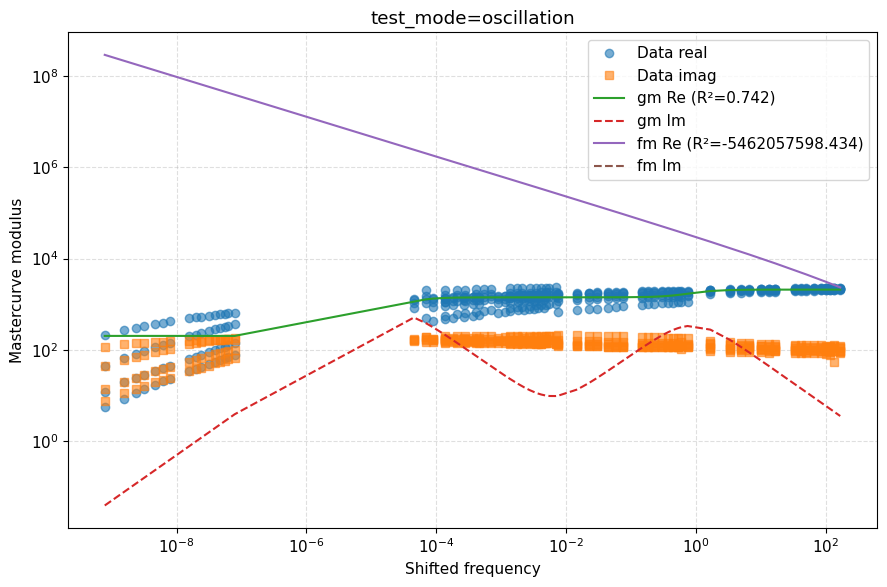

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<45:04,  1.48it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|▏         | 59/4000 [00:00<00:38, 102.27it/s, 31 steps of size 3.10e-02. acc. prob=0.76]

warmup:   4%|▍         | 151/4000 [00:00<00:14, 264.11it/s, 127 steps of size 1.92e-01. acc. prob=0.77]

warmup:   5%|▌         | 211/4000 [00:01<00:14, 265.23it/s, 255 steps of size 2.92e-02. acc. prob=0.78]

warmup:   6%|▋         | 258/4000 [00:01<00:13, 282.20it/s, 7 steps of size 5.20e-03. acc. prob=0.77]  

warmup:   8%|▊         | 300/4000 [00:01<00:13, 280.83it/s, 127 steps of size 3.99e-02. acc. prob=0.78]

warmup:   9%|▊         | 342/4000 [00:01<00:11, 309.23it/s, 127 steps of size 3.70e-02. acc. prob=0.78]

warmup:  10%|▉         | 389/4000 [00:01<00:10, 345.85it/s, 255 steps of size 3.70e-02. acc. prob=0.78]

warmup:  11%|█         | 436/4000 [00:01<00:09, 374.53it/s, 127 steps of size 3.26e-02. acc. prob=0.78]

warmup:  12%|█▏        | 479/4000 [00:01<00:10, 328.35it/s, 255 steps of size 3.01e-02. acc. prob=0.78]

warmup:  13%|█▎        | 517/4000 [00:01<00:10, 334.28it/s, 4 steps of size 1.05e-02. acc. prob=0.78]  

warmup:  14%|█▍        | 554/4000 [00:02<00:10, 336.84it/s, 3 steps of size 1.28e-02. acc. prob=0.78]

warmup:  15%|█▍        | 594/4000 [00:02<00:09, 350.96it/s, 127 steps of size 2.85e-02. acc. prob=0.79]

warmup:  16%|█▌        | 638/4000 [00:02<00:09, 373.23it/s, 191 steps of size 3.15e-02. acc. prob=0.79]

warmup:  17%|█▋        | 680/4000 [00:02<00:08, 385.53it/s, 63 steps of size 2.05e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 720/4000 [00:02<00:08, 388.41it/s, 255 steps of size 1.48e-02. acc. prob=0.79]

warmup:  19%|█▉        | 760/4000 [00:02<00:08, 380.45it/s, 383 steps of size 1.76e-02. acc. prob=0.79]

warmup:  20%|██        | 804/4000 [00:02<00:08, 395.72it/s, 63 steps of size 3.43e-02. acc. prob=0.79] 

warmup:  21%|██        | 845/4000 [00:02<00:08, 360.65it/s, 127 steps of size 3.40e-02. acc. prob=0.79]

warmup:  22%|██▏       | 889/4000 [00:02<00:08, 380.60it/s, 127 steps of size 2.72e-02. acc. prob=0.79]

warmup:  23%|██▎       | 930/4000 [00:03<00:07, 387.19it/s, 127 steps of size 3.44e-02. acc. prob=0.79]

warmup:  24%|██▍       | 970/4000 [00:03<00:07, 387.28it/s, 127 steps of size 5.54e-02. acc. prob=0.79]

sample:  25%|██▌       | 1010/4000 [00:03<00:08, 335.22it/s, 143 steps of size 1.86e-02. acc. prob=0.95]

sample:  26%|██▌       | 1046/4000 [00:03<00:08, 330.44it/s, 71 steps of size 1.86e-02. acc. prob=0.96] 

sample:  27%|██▋       | 1081/4000 [00:03<00:09, 317.21it/s, 159 steps of size 1.86e-02. acc. prob=0.96]

sample:  28%|██▊       | 1114/4000 [00:03<00:09, 306.06it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  29%|██▊       | 1146/4000 [00:03<00:09, 302.17it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  29%|██▉       | 1177/4000 [00:03<00:09, 294.87it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  30%|███       | 1207/4000 [00:03<00:09, 295.38it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  31%|███       | 1237/4000 [00:04<00:09, 288.63it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  32%|███▏      | 1272/4000 [00:04<00:08, 304.73it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  33%|███▎      | 1303/4000 [00:04<00:09, 295.58it/s, 191 steps of size 1.86e-02. acc. prob=0.96]

sample:  33%|███▎      | 1335/4000 [00:04<00:08, 300.94it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  34%|███▍      | 1367/4000 [00:04<00:08, 305.54it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  35%|███▍      | 1398/4000 [00:04<00:08, 297.39it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  36%|███▌      | 1428/4000 [00:04<00:08, 295.36it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  36%|███▋      | 1458/4000 [00:04<00:08, 285.52it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  37%|███▋      | 1487/4000 [00:04<00:08, 280.76it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  38%|███▊      | 1520/4000 [00:05<00:08, 293.11it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  39%|███▉      | 1552/4000 [00:05<00:08, 299.55it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  40%|███▉      | 1583/4000 [00:05<00:07, 302.35it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  40%|████      | 1617/4000 [00:05<00:07, 311.06it/s, 163 steps of size 1.86e-02. acc. prob=0.96]

sample:  41%|████▏     | 1650/4000 [00:05<00:07, 313.18it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  42%|████▏     | 1682/4000 [00:05<00:07, 298.76it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  43%|████▎     | 1713/4000 [00:05<00:07, 294.70it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  44%|████▎     | 1743/4000 [00:05<00:07, 291.67it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  44%|████▍     | 1775/4000 [00:05<00:07, 298.93it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  45%|████▌     | 1805/4000 [00:05<00:07, 299.20it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  46%|████▌     | 1835/4000 [00:06<00:07, 292.56it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  47%|████▋     | 1865/4000 [00:06<00:07, 286.50it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  47%|████▋     | 1896/4000 [00:06<00:07, 291.17it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  48%|████▊     | 1926/4000 [00:06<00:07, 290.91it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  49%|████▉     | 1956/4000 [00:06<00:07, 290.60it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  50%|████▉     | 1986/4000 [00:06<00:07, 284.65it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  50%|█████     | 2015/4000 [00:06<00:07, 274.69it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  51%|█████     | 2043/4000 [00:06<00:07, 276.15it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  52%|█████▏    | 2072/4000 [00:06<00:06, 276.78it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  53%|█████▎    | 2101/4000 [00:07<00:06, 278.42it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  53%|█████▎    | 2133/4000 [00:07<00:06, 286.67it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  54%|█████▍    | 2162/4000 [00:07<00:06, 285.45it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  55%|█████▍    | 2191/4000 [00:07<00:06, 276.66it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  56%|█████▌    | 2222/4000 [00:07<00:06, 283.23it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  56%|█████▋    | 2251/4000 [00:07<00:06, 274.86it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  57%|█████▋    | 2280/4000 [00:07<00:06, 276.40it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  58%|█████▊    | 2314/4000 [00:07<00:05, 293.00it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  59%|█████▊    | 2348/4000 [00:07<00:05, 305.44it/s, 103 steps of size 1.86e-02. acc. prob=0.96]

sample:  59%|█████▉    | 2379/4000 [00:08<00:05, 297.11it/s, 63 steps of size 1.86e-02. acc. prob=0.96] 

sample:  60%|██████    | 2410/4000 [00:08<00:05, 299.84it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  61%|██████    | 2445/4000 [00:08<00:05, 310.76it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  62%|██████▏   | 2477/4000 [00:08<00:05, 303.67it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  63%|██████▎   | 2508/4000 [00:08<00:04, 304.66it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  63%|██████▎   | 2539/4000 [00:08<00:04, 301.66it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  64%|██████▍   | 2570/4000 [00:08<00:04, 291.12it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  65%|██████▌   | 2601/4000 [00:08<00:04, 295.30it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  66%|██████▌   | 2632/4000 [00:08<00:04, 299.53it/s, 63 steps of size 1.86e-02. acc. prob=0.96] 

sample:  67%|██████▋   | 2663/4000 [00:08<00:04, 297.20it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  67%|██████▋   | 2693/4000 [00:09<00:04, 294.63it/s, 15 steps of size 1.86e-02. acc. prob=0.96] 

sample:  68%|██████▊   | 2723/4000 [00:09<00:04, 294.96it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  69%|██████▉   | 2754/4000 [00:09<00:04, 295.23it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  70%|██████▉   | 2786/4000 [00:09<00:04, 300.65it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  70%|███████   | 2817/4000 [00:09<00:04, 294.19it/s, 191 steps of size 1.86e-02. acc. prob=0.96]

sample:  71%|███████   | 2847/4000 [00:09<00:03, 295.48it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  72%|███████▏  | 2877/4000 [00:09<00:03, 284.64it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  73%|███████▎  | 2909/4000 [00:09<00:03, 293.63it/s, 63 steps of size 1.86e-02. acc. prob=0.96] 

sample:  73%|███████▎  | 2939/4000 [00:09<00:03, 281.74it/s, 383 steps of size 1.86e-02. acc. prob=0.96]

sample:  74%|███████▍  | 2969/4000 [00:10<00:03, 285.01it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  75%|███████▍  | 2998/4000 [00:10<00:03, 286.23it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  76%|███████▌  | 3027/4000 [00:10<00:03, 286.28it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  76%|███████▋  | 3056/4000 [00:10<00:03, 280.16it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  77%|███████▋  | 3085/4000 [00:10<00:03, 282.51it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  78%|███████▊  | 3114/4000 [00:10<00:03, 283.71it/s, 63 steps of size 1.86e-02. acc. prob=0.96] 

sample:  79%|███████▊  | 3145/4000 [00:10<00:02, 289.92it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  79%|███████▉  | 3175/4000 [00:10<00:02, 292.47it/s, 107 steps of size 1.86e-02. acc. prob=0.96]

sample:  80%|████████  | 3205/4000 [00:10<00:02, 294.50it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  81%|████████  | 3237/4000 [00:10<00:02, 297.92it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  82%|████████▏ | 3268/4000 [00:11<00:02, 299.15it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  82%|████████▏ | 3298/4000 [00:11<00:02, 296.36it/s, 211 steps of size 1.86e-02. acc. prob=0.96]

sample:  83%|████████▎ | 3328/4000 [00:11<00:02, 286.51it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  84%|████████▍ | 3357/4000 [00:11<00:02, 280.86it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  85%|████████▍ | 3388/4000 [00:11<00:02, 286.25it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  85%|████████▌ | 3417/4000 [00:11<00:02, 278.57it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  86%|████████▌ | 3447/4000 [00:11<00:01, 283.74it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  87%|████████▋ | 3476/4000 [00:11<00:01, 282.71it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  88%|████████▊ | 3507/4000 [00:11<00:01, 289.38it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  88%|████████▊ | 3539/4000 [00:11<00:01, 296.52it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  89%|████████▉ | 3570/4000 [00:12<00:01, 299.85it/s, 191 steps of size 1.86e-02. acc. prob=0.96]

sample:  90%|█████████ | 3601/4000 [00:12<00:01, 298.57it/s, 63 steps of size 1.86e-02. acc. prob=0.96] 

sample:  91%|█████████ | 3633/4000 [00:12<00:01, 302.29it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  92%|█████████▏| 3665/4000 [00:12<00:01, 307.38it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  92%|█████████▏| 3696/4000 [00:12<00:01, 260.84it/s, 63 steps of size 1.86e-02. acc. prob=0.96] 

sample:  93%|█████████▎| 3724/4000 [00:12<00:01, 265.31it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  94%|█████████▍| 3754/4000 [00:12<00:00, 273.02it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  95%|█████████▍| 3788/4000 [00:12<00:00, 290.12it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  96%|█████████▌| 3820/4000 [00:12<00:00, 295.33it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  96%|█████████▋| 3851/4000 [00:13<00:00, 299.29it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  97%|█████████▋| 3882/4000 [00:13<00:00, 288.16it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  98%|█████████▊| 3912/4000 [00:13<00:00, 290.53it/s, 127 steps of size 1.86e-02. acc. prob=0.96]

sample:  99%|█████████▊| 3942/4000 [00:13<00:00, 293.01it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample:  99%|█████████▉| 3973/4000 [00:13<00:00, 296.70it/s, 255 steps of size 1.86e-02. acc. prob=0.96]

sample: 100%|██████████| 4000/4000 [00:13<00:00, 294.68it/s, 63 steps of size 1.86e-02. acc. prob=0.96] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 91/4000 [00:00<00:04, 896.40it/s, 271 steps of size 1.55e-02. acc. prob=0.76]

warmup:   5%|▍         | 181/4000 [00:00<00:07, 500.43it/s, 63 steps of size 5.58e-02. acc. prob=0.77]

warmup:   6%|▌         | 241/4000 [00:00<00:07, 482.26it/s, 63 steps of size 5.27e-02. acc. prob=0.78]

warmup:   7%|▋         | 294/4000 [00:00<00:08, 413.59it/s, 127 steps of size 4.03e-02. acc. prob=0.78]

warmup:   8%|▊         | 339/4000 [00:00<00:08, 413.99it/s, 63 steps of size 2.03e-02. acc. prob=0.78] 

warmup:  10%|▉         | 383/4000 [00:00<00:08, 402.28it/s, 127 steps of size 4.82e-02. acc. prob=0.78]

warmup:  11%|█         | 426/4000 [00:00<00:08, 409.02it/s, 127 steps of size 1.93e-02. acc. prob=0.78]

warmup:  12%|█▏        | 468/4000 [00:01<00:09, 392.20it/s, 127 steps of size 9.19e-03. acc. prob=0.78]

warmup:  13%|█▎        | 508/4000 [00:01<00:10, 328.67it/s, 127 steps of size 1.67e-02. acc. prob=0.78]

warmup:  14%|█▎        | 543/4000 [00:01<00:10, 332.73it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  15%|█▍        | 581/4000 [00:01<00:09, 344.10it/s, 127 steps of size 2.08e-02. acc. prob=0.78]

warmup:  16%|█▌        | 622/4000 [00:01<00:09, 361.13it/s, 91 steps of size 2.35e-02. acc. prob=0.79] 

warmup:  17%|█▋        | 669/4000 [00:01<00:08, 389.11it/s, 255 steps of size 2.77e-02. acc. prob=0.79]

warmup:  18%|█▊        | 715/4000 [00:01<00:08, 408.44it/s, 255 steps of size 2.52e-02. acc. prob=0.79]

warmup:  19%|█▉        | 757/4000 [00:01<00:07, 409.81it/s, 27 steps of size 1.97e-02. acc. prob=0.79] 

warmup:  20%|██        | 800/4000 [00:01<00:07, 415.28it/s, 97 steps of size 3.80e-02. acc. prob=0.79]

warmup:  21%|██▏       | 851/4000 [00:02<00:07, 442.01it/s, 127 steps of size 2.92e-02. acc. prob=0.79]

warmup:  23%|██▎       | 901/4000 [00:02<00:06, 457.87it/s, 127 steps of size 3.54e-02. acc. prob=0.79]

warmup:  24%|██▎       | 949/4000 [00:02<00:06, 461.07it/s, 127 steps of size 2.76e-02. acc. prob=0.79]

warmup:  25%|██▍       | 996/4000 [00:02<00:08, 349.58it/s, 255 steps of size 3.49e-02. acc. prob=0.79]

sample:  26%|██▌       | 1036/4000 [00:02<00:09, 326.68it/s, 383 steps of size 1.84e-02. acc. prob=0.95]

sample:  27%|██▋       | 1072/4000 [00:02<00:09, 319.77it/s, 63 steps of size 1.84e-02. acc. prob=0.94] 

sample:  28%|██▊       | 1107/4000 [00:02<00:09, 303.58it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  28%|██▊       | 1140/4000 [00:02<00:09, 306.51it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  29%|██▉       | 1172/4000 [00:03<00:09, 298.82it/s, 111 steps of size 1.84e-02. acc. prob=0.95]

sample:  30%|███       | 1203/4000 [00:03<00:09, 290.05it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  31%|███       | 1233/4000 [00:03<00:09, 282.97it/s, 127 steps of size 1.84e-02. acc. prob=0.95]

sample:  32%|███▏      | 1263/4000 [00:03<00:09, 284.09it/s, 243 steps of size 1.84e-02. acc. prob=0.95]

sample:  32%|███▏      | 1294/4000 [00:03<00:09, 289.38it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  33%|███▎      | 1325/4000 [00:03<00:09, 292.76it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  34%|███▍      | 1355/4000 [00:03<00:09, 285.26it/s, 111 steps of size 1.84e-02. acc. prob=0.96]

sample:  35%|███▍      | 1384/4000 [00:03<00:09, 281.76it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  35%|███▌      | 1416/4000 [00:03<00:08, 292.26it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  36%|███▌      | 1446/4000 [00:04<00:08, 284.58it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  37%|███▋      | 1475/4000 [00:04<00:08, 282.20it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  38%|███▊      | 1504/4000 [00:04<00:09, 270.01it/s, 283 steps of size 1.84e-02. acc. prob=0.96]

sample:  38%|███▊      | 1532/4000 [00:04<00:09, 269.09it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  39%|███▉      | 1563/4000 [00:04<00:08, 276.77it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  40%|███▉      | 1593/4000 [00:04<00:08, 282.84it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  41%|████      | 1622/4000 [00:04<00:08, 273.85it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  41%|████▏     | 1650/4000 [00:04<00:08, 274.48it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  42%|████▏     | 1681/4000 [00:04<00:08, 282.89it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  43%|████▎     | 1710/4000 [00:05<00:08, 284.53it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  44%|████▎     | 1742/4000 [00:05<00:07, 293.11it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  44%|████▍     | 1772/4000 [00:05<00:07, 281.60it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  45%|████▌     | 1801/4000 [00:05<00:07, 283.76it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  46%|████▌     | 1832/4000 [00:05<00:07, 290.11it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  47%|████▋     | 1862/4000 [00:05<00:07, 292.66it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  47%|████▋     | 1896/4000 [00:05<00:06, 304.97it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  48%|████▊     | 1927/4000 [00:05<00:06, 304.05it/s, 31 steps of size 1.84e-02. acc. prob=0.96] 

sample:  49%|████▉     | 1958/4000 [00:05<00:06, 300.54it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  50%|████▉     | 1989/4000 [00:05<00:06, 294.52it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  50%|█████     | 2019/4000 [00:06<00:06, 293.29it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  51%|█████     | 2049/4000 [00:06<00:06, 290.57it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  52%|█████▏    | 2079/4000 [00:06<00:06, 287.19it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  53%|█████▎    | 2108/4000 [00:06<00:06, 280.52it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  53%|█████▎    | 2137/4000 [00:06<00:06, 278.72it/s, 191 steps of size 1.84e-02. acc. prob=0.96]

sample:  54%|█████▍    | 2169/4000 [00:06<00:06, 289.72it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  55%|█████▍    | 2199/4000 [00:06<00:06, 291.92it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  56%|█████▌    | 2229/4000 [00:06<00:06, 284.69it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  56%|█████▋    | 2258/4000 [00:06<00:06, 283.97it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  57%|█████▋    | 2287/4000 [00:07<00:06, 284.70it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  58%|█████▊    | 2316/4000 [00:07<00:06, 277.75it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  59%|█████▊    | 2345/4000 [00:07<00:05, 281.28it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  59%|█████▉    | 2376/4000 [00:07<00:05, 288.44it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  60%|██████    | 2405/4000 [00:07<00:05, 283.00it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  61%|██████    | 2436/4000 [00:07<00:05, 287.93it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  62%|██████▏   | 2465/4000 [00:07<00:05, 284.33it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  62%|██████▏   | 2498/4000 [00:07<00:05, 297.30it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  63%|██████▎   | 2528/4000 [00:07<00:05, 287.34it/s, 63 steps of size 1.84e-02. acc. prob=0.96] 

sample:  64%|██████▍   | 2557/4000 [00:07<00:05, 250.01it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  65%|██████▍   | 2589/4000 [00:08<00:05, 266.89it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  65%|██████▌   | 2619/4000 [00:08<00:05, 275.25it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  66%|██████▌   | 2649/4000 [00:08<00:04, 280.85it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  67%|██████▋   | 2678/4000 [00:08<00:04, 280.46it/s, 95 steps of size 1.84e-02. acc. prob=0.96] 

sample:  68%|██████▊   | 2708/4000 [00:08<00:04, 284.33it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  68%|██████▊   | 2737/4000 [00:08<00:04, 276.91it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  69%|██████▉   | 2767/4000 [00:08<00:04, 280.63it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  70%|██████▉   | 2796/4000 [00:08<00:04, 282.73it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  71%|███████   | 2825/4000 [00:08<00:04, 268.76it/s, 191 steps of size 1.84e-02. acc. prob=0.96]

sample:  71%|███████▏  | 2854/4000 [00:09<00:04, 272.52it/s, 223 steps of size 1.84e-02. acc. prob=0.96]

sample:  72%|███████▏  | 2882/4000 [00:09<00:04, 266.56it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  73%|███████▎  | 2911/4000 [00:09<00:04, 271.82it/s, 383 steps of size 1.84e-02. acc. prob=0.96]

sample:  73%|███████▎  | 2939/4000 [00:09<00:03, 265.70it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  74%|███████▍  | 2969/4000 [00:09<00:03, 274.22it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  75%|███████▍  | 2997/4000 [00:09<00:03, 264.60it/s, 511 steps of size 1.84e-02. acc. prob=0.96]

sample:  76%|███████▌  | 3028/4000 [00:09<00:03, 273.74it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  76%|███████▋  | 3058/4000 [00:09<00:03, 277.75it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  77%|███████▋  | 3086/4000 [00:09<00:03, 275.86it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  78%|███████▊  | 3116/4000 [00:10<00:03, 281.07it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  79%|███████▊  | 3147/4000 [00:10<00:02, 287.33it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  79%|███████▉  | 3176/4000 [00:10<00:02, 285.66it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  80%|████████  | 3205/4000 [00:10<00:02, 285.64it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  81%|████████  | 3234/4000 [00:10<00:02, 278.41it/s, 383 steps of size 1.84e-02. acc. prob=0.96]

sample:  82%|████████▏ | 3264/4000 [00:10<00:02, 284.15it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  82%|████████▏ | 3294/4000 [00:10<00:02, 288.02it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  83%|████████▎ | 3325/4000 [00:10<00:02, 290.67it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  84%|████████▍ | 3355/4000 [00:10<00:02, 292.16it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  85%|████████▍ | 3385/4000 [00:10<00:02, 291.56it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  85%|████████▌ | 3418/4000 [00:11<00:01, 300.08it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  86%|████████▌ | 3449/4000 [00:11<00:01, 291.16it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  87%|████████▋ | 3481/4000 [00:11<00:01, 297.31it/s, 159 steps of size 1.84e-02. acc. prob=0.96]

sample:  88%|████████▊ | 3511/4000 [00:11<00:01, 294.09it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  89%|████████▊ | 3541/4000 [00:11<00:01, 282.25it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  89%|████████▉ | 3576/4000 [00:11<00:01, 297.94it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  90%|█████████ | 3606/4000 [00:11<00:01, 286.97it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  91%|█████████ | 3639/4000 [00:11<00:01, 292.88it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  92%|█████████▏| 3670/4000 [00:11<00:01, 294.81it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  93%|█████████▎| 3702/4000 [00:12<00:00, 301.85it/s, 111 steps of size 1.84e-02. acc. prob=0.96]

sample:  93%|█████████▎| 3733/4000 [00:12<00:00, 300.61it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  94%|█████████▍| 3768/4000 [00:12<00:00, 312.59it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  95%|█████████▌| 3800/4000 [00:12<00:00, 305.57it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  96%|█████████▌| 3831/4000 [00:12<00:00, 299.35it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  97%|█████████▋| 3864/4000 [00:12<00:00, 305.04it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  97%|█████████▋| 3895/4000 [00:12<00:00, 289.00it/s, 127 steps of size 1.84e-02. acc. prob=0.96]

sample:  98%|█████████▊| 3925/4000 [00:12<00:00, 289.73it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample:  99%|█████████▉| 3955/4000 [00:12<00:00, 285.86it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample: 100%|█████████▉| 3987/4000 [00:12<00:00, 292.04it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

sample: 100%|██████████| 4000/4000 [00:13<00:00, 307.40it/s, 255 steps of size 1.84e-02. acc. prob=0.96]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   3%|▎         | 105/4000 [00:00<00:03, 976.08it/s, 575 steps of size 1.81e-02. acc. prob=0.76]

warmup:   5%|▌         | 203/4000 [00:00<00:05, 634.58it/s, 13 steps of size 1.54e-02. acc. prob=0.77] 

warmup:   7%|▋         | 273/4000 [00:00<00:07, 506.95it/s, 127 steps of size 4.11e-02. acc. prob=0.78]

warmup:   8%|▊         | 329/4000 [00:00<00:09, 388.60it/s, 63 steps of size 4.68e-02. acc. prob=0.78] 

warmup:   9%|▉         | 373/4000 [00:00<00:10, 352.12it/s, 16 steps of size 2.11e-02. acc. prob=0.78]

warmup:  10%|█         | 411/4000 [00:00<00:10, 353.50it/s, 127 steps of size 2.57e-02. acc. prob=0.78]

warmup:  11%|█▏        | 450/4000 [00:01<00:09, 359.31it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  12%|█▏        | 488/4000 [00:01<00:09, 351.62it/s, 255 steps of size 3.98e-02. acc. prob=0.78]

warmup:  13%|█▎        | 524/4000 [00:01<00:11, 310.36it/s, 127 steps of size 5.11e-02. acc. prob=0.78]

warmup:  14%|█▍        | 564/4000 [00:01<00:10, 330.87it/s, 255 steps of size 2.51e-02. acc. prob=0.78]

warmup:  15%|█▌        | 605/4000 [00:01<00:09, 349.09it/s, 255 steps of size 1.82e-02. acc. prob=0.78]

warmup:  16%|█▌        | 646/4000 [00:01<00:09, 364.43it/s, 191 steps of size 3.15e-02. acc. prob=0.79]

warmup:  17%|█▋        | 686/4000 [00:01<00:08, 373.24it/s, 67 steps of size 3.29e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 730/4000 [00:01<00:08, 391.72it/s, 63 steps of size 3.08e-02. acc. prob=0.79]

warmup:  19%|█▉        | 770/4000 [00:01<00:08, 388.97it/s, 127 steps of size 2.86e-02. acc. prob=0.79]

warmup:  20%|██        | 820/4000 [00:02<00:07, 419.29it/s, 127 steps of size 3.14e-02. acc. prob=0.79]

warmup:  22%|██▏       | 863/4000 [00:02<00:07, 419.68it/s, 127 steps of size 3.67e-02. acc. prob=0.79]

warmup:  23%|██▎       | 912/4000 [00:02<00:07, 438.12it/s, 127 steps of size 3.41e-02. acc. prob=0.79]

warmup:  24%|██▍       | 957/4000 [00:02<00:06, 434.90it/s, 79 steps of size 3.14e-02. acc. prob=0.79] 

sample:  25%|██▌       | 1001/4000 [00:02<00:07, 396.72it/s, 255 steps of size 2.74e-02. acc. prob=0.99]

sample:  26%|██▌       | 1042/4000 [00:02<00:07, 398.28it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  27%|██▋       | 1083/4000 [00:02<00:07, 401.25it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  28%|██▊       | 1124/4000 [00:02<00:07, 402.15it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  29%|██▉       | 1167/4000 [00:02<00:06, 409.03it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  30%|███       | 1210/4000 [00:03<00:06, 414.35it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  31%|███▏      | 1252/4000 [00:03<00:06, 411.27it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  32%|███▏      | 1294/4000 [00:03<00:06, 406.85it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  33%|███▎      | 1335/4000 [00:03<00:06, 406.10it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  34%|███▍      | 1378/4000 [00:03<00:06, 409.96it/s, 255 steps of size 2.74e-02. acc. prob=0.93]

sample:  36%|███▌      | 1420/4000 [00:03<00:06, 408.62it/s, 83 steps of size 2.74e-02. acc. prob=0.93] 

sample:  37%|███▋      | 1461/4000 [00:03<00:06, 405.72it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  38%|███▊      | 1502/4000 [00:03<00:06, 370.59it/s, 191 steps of size 2.74e-02. acc. prob=0.92]

sample:  39%|███▊      | 1544/4000 [00:03<00:06, 383.12it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  40%|███▉      | 1588/4000 [00:03<00:06, 398.24it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  41%|████      | 1629/4000 [00:04<00:05, 397.29it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  42%|████▏     | 1673/4000 [00:04<00:05, 403.67it/s, 255 steps of size 2.74e-02. acc. prob=0.92]

sample:  43%|████▎     | 1718/4000 [00:04<00:05, 415.27it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  44%|████▍     | 1765/4000 [00:04<00:05, 431.05it/s, 63 steps of size 2.74e-02. acc. prob=0.92] 

sample:  45%|████▌     | 1809/4000 [00:04<00:05, 416.51it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  46%|████▋     | 1852/4000 [00:04<00:05, 419.57it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  47%|████▋     | 1895/4000 [00:04<00:05, 415.50it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  48%|████▊     | 1937/4000 [00:04<00:05, 407.81it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  50%|████▉     | 1980/4000 [00:04<00:04, 413.69it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  51%|█████     | 2022/4000 [00:05<00:04, 413.67it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2070/4000 [00:05<00:04, 431.59it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  53%|█████▎    | 2114/4000 [00:05<00:04, 427.09it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  54%|█████▍    | 2158/4000 [00:05<00:04, 430.38it/s, 63 steps of size 2.74e-02. acc. prob=0.93] 

sample:  55%|█████▌    | 2202/4000 [00:05<00:04, 426.86it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2248/4000 [00:05<00:04, 431.98it/s, 255 steps of size 2.74e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2293/4000 [00:05<00:03, 434.67it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2337/4000 [00:05<00:03, 434.21it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  60%|█████▉    | 2381/4000 [00:05<00:03, 434.31it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  61%|██████    | 2425/4000 [00:05<00:03, 428.03it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2469/4000 [00:06<00:03, 431.38it/s, 255 steps of size 2.74e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2514/4000 [00:06<00:03, 434.47it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2558/4000 [00:06<00:03, 425.64it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  65%|██████▌   | 2601/4000 [00:06<00:03, 417.30it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2647/4000 [00:06<00:03, 428.48it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2690/4000 [00:06<00:03, 427.56it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2733/4000 [00:06<00:02, 427.01it/s, 63 steps of size 2.74e-02. acc. prob=0.93] 

sample:  69%|██████▉   | 2776/4000 [00:06<00:02, 409.25it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  70%|███████   | 2818/4000 [00:06<00:02, 410.93it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  72%|███████▏  | 2861/4000 [00:06<00:02, 415.08it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2905/4000 [00:07<00:02, 419.87it/s, 191 steps of size 2.74e-02. acc. prob=0.92]

sample:  74%|███████▎  | 2948/4000 [00:07<00:02, 409.17it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  75%|███████▍  | 2990/4000 [00:07<00:02, 402.30it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  76%|███████▌  | 3032/4000 [00:07<00:02, 404.60it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  77%|███████▋  | 3076/4000 [00:07<00:02, 414.24it/s, 63 steps of size 2.74e-02. acc. prob=0.93] 

sample:  78%|███████▊  | 3120/4000 [00:07<00:02, 419.73it/s, 191 steps of size 2.74e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3164/4000 [00:07<00:01, 423.90it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  80%|████████  | 3207/4000 [00:07<00:01, 417.94it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  81%|████████▏ | 3252/4000 [00:07<00:01, 424.77it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3295/4000 [00:08<00:01, 416.46it/s, 255 steps of size 2.74e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3337/4000 [00:08<00:01, 415.53it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  84%|████████▍ | 3380/4000 [00:08<00:01, 414.74it/s, 255 steps of size 2.74e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3424/4000 [00:08<00:01, 420.44it/s, 255 steps of size 2.74e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3473/4000 [00:08<00:01, 438.44it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3517/4000 [00:08<00:01, 431.34it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  89%|████████▉ | 3561/4000 [00:08<00:01, 429.75it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  90%|█████████ | 3606/4000 [00:08<00:00, 434.16it/s, 191 steps of size 2.74e-02. acc. prob=0.93]

sample:  91%|█████████▏| 3650/4000 [00:08<00:00, 427.46it/s, 7 steps of size 2.74e-02. acc. prob=0.92]  

sample:  92%|█████████▏| 3694/4000 [00:08<00:00, 429.24it/s, 95 steps of size 2.74e-02. acc. prob=0.92]

sample:  93%|█████████▎| 3737/4000 [00:09<00:00, 428.82it/s, 191 steps of size 2.74e-02. acc. prob=0.92]

sample:  94%|█████████▍| 3780/4000 [00:09<00:00, 423.72it/s, 127 steps of size 2.74e-02. acc. prob=0.92]

sample:  96%|█████████▌| 3823/4000 [00:09<00:00, 416.58it/s, 255 steps of size 2.74e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3866/4000 [00:09<00:00, 419.62it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3909/4000 [00:09<00:00, 421.04it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3952/4000 [00:09<00:00, 420.46it/s, 255 steps of size 2.74e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3998/4000 [00:09<00:00, 431.18it/s, 63 steps of size 2.74e-02. acc. prob=0.93] 

sample: 100%|██████████| 4000/4000 [00:09<00:00, 413.69it/s, 127 steps of size 2.74e-02. acc. prob=0.93]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|▏         | 54/4000 [00:00<00:07, 519.71it/s, 271 steps of size 1.74e-02. acc. prob=0.75]

warmup:   3%|▎         | 111/4000 [00:00<00:07, 538.44it/s, 255 steps of size 3.97e-02. acc. prob=0.77]

warmup:   4%|▍         | 165/4000 [00:00<00:10, 378.10it/s, 127 steps of size 4.40e-02. acc. prob=0.77]

warmup:   5%|▌         | 207/4000 [00:00<00:11, 343.35it/s, 127 steps of size 3.09e-02. acc. prob=0.77]

warmup:   6%|▌         | 244/4000 [00:00<00:11, 318.99it/s, 63 steps of size 2.22e-02. acc. prob=0.78] 

warmup:   7%|▋         | 278/4000 [00:00<00:12, 303.06it/s, 27 steps of size 1.64e-02. acc. prob=0.78]

warmup:   8%|▊         | 311/4000 [00:00<00:11, 308.46it/s, 127 steps of size 4.19e-02. acc. prob=0.78]

warmup:   9%|▉         | 351/4000 [00:01<00:10, 332.55it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  10%|▉         | 389/4000 [00:01<00:10, 344.00it/s, 255 steps of size 2.23e-02. acc. prob=0.78]

warmup:  11%|█         | 436/4000 [00:01<00:09, 378.70it/s, 127 steps of size 3.97e-02. acc. prob=0.78]

warmup:  12%|█▏        | 475/4000 [00:01<00:09, 354.62it/s, 127 steps of size 1.77e-02. acc. prob=0.78]

warmup:  13%|█▎        | 512/4000 [00:01<00:10, 329.87it/s, 127 steps of size 3.36e-02. acc. prob=0.78]

warmup:  14%|█▎        | 546/4000 [00:01<00:10, 327.96it/s, 63 steps of size 1.08e-02. acc. prob=0.78] 

warmup:  15%|█▍        | 583/4000 [00:01<00:10, 337.93it/s, 255 steps of size 2.29e-02. acc. prob=0.79]

warmup:  16%|█▌        | 623/4000 [00:01<00:09, 354.81it/s, 63 steps of size 3.78e-02. acc. prob=0.79] 

warmup:  17%|█▋        | 668/4000 [00:01<00:08, 380.14it/s, 191 steps of size 2.44e-02. acc. prob=0.79]

warmup:  18%|█▊        | 708/4000 [00:01<00:08, 382.45it/s, 191 steps of size 3.02e-02. acc. prob=0.79]

warmup:  19%|█▉        | 750/4000 [00:02<00:08, 391.57it/s, 127 steps of size 3.45e-02. acc. prob=0.79]

warmup:  20%|█▉        | 792/4000 [00:02<00:08, 399.23it/s, 127 steps of size 3.31e-02. acc. prob=0.79]

warmup:  21%|██        | 834/4000 [00:02<00:07, 403.75it/s, 127 steps of size 3.35e-02. acc. prob=0.79]

warmup:  22%|██▏       | 884/4000 [00:02<00:07, 431.98it/s, 255 steps of size 1.80e-02. acc. prob=0.79]

warmup:  23%|██▎       | 928/4000 [00:02<00:07, 430.46it/s, 19 steps of size 1.39e-02. acc. prob=0.79] 

warmup:  24%|██▍       | 972/4000 [00:02<00:07, 391.67it/s, 511 steps of size 7.47e-03. acc. prob=0.79]

sample:  25%|██▌       | 1012/4000 [00:02<00:08, 359.05it/s, 255 steps of size 2.03e-02. acc. prob=0.97]

sample:  26%|██▌       | 1049/4000 [00:02<00:08, 328.27it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  27%|██▋       | 1083/4000 [00:03<00:09, 302.30it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  28%|██▊       | 1115/4000 [00:03<00:10, 286.54it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  29%|██▊       | 1145/4000 [00:03<00:09, 289.02it/s, 191 steps of size 2.03e-02. acc. prob=0.94]

sample:  30%|██▉       | 1180/4000 [00:03<00:09, 304.13it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  30%|███       | 1213/4000 [00:03<00:09, 309.48it/s, 115 steps of size 2.03e-02. acc. prob=0.94]

sample:  31%|███       | 1247/4000 [00:03<00:08, 316.49it/s, 255 steps of size 2.03e-02. acc. prob=0.94]

sample:  32%|███▏      | 1281/4000 [00:03<00:08, 321.34it/s, 127 steps of size 2.03e-02. acc. prob=0.94]

sample:  33%|███▎      | 1317/4000 [00:03<00:08, 332.21it/s, 127 steps of size 2.03e-02. acc. prob=0.94]

sample:  34%|███▍      | 1351/4000 [00:03<00:08, 321.49it/s, 255 steps of size 2.03e-02. acc. prob=0.94]

sample:  35%|███▍      | 1384/4000 [00:04<00:08, 314.50it/s, 159 steps of size 2.03e-02. acc. prob=0.94]

sample:  35%|███▌      | 1416/4000 [00:04<00:08, 306.57it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  36%|███▌      | 1447/4000 [00:04<00:08, 306.32it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  37%|███▋      | 1478/4000 [00:04<00:08, 298.66it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  38%|███▊      | 1508/4000 [00:04<00:08, 294.56it/s, 95 steps of size 2.03e-02. acc. prob=0.95] 

sample:  38%|███▊      | 1538/4000 [00:04<00:08, 295.05it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  39%|███▉      | 1568/4000 [00:04<00:08, 293.59it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  40%|███▉      | 1598/4000 [00:04<00:08, 289.75it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  41%|████      | 1629/4000 [00:04<00:08, 293.26it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  42%|████▏     | 1660/4000 [00:04<00:07, 295.20it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  42%|████▏     | 1691/4000 [00:05<00:07, 298.10it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  43%|████▎     | 1722/4000 [00:05<00:07, 301.37it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  44%|████▍     | 1755/4000 [00:05<00:07, 308.62it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  45%|████▍     | 1787/4000 [00:05<00:07, 308.53it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  45%|████▌     | 1819/4000 [00:05<00:07, 308.46it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  46%|████▋     | 1850/4000 [00:05<00:07, 298.28it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  47%|████▋     | 1880/4000 [00:05<00:07, 289.11it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  48%|████▊     | 1915/4000 [00:05<00:06, 305.11it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  49%|████▊     | 1946/4000 [00:05<00:06, 300.79it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  49%|████▉     | 1978/4000 [00:05<00:06, 305.34it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  50%|█████     | 2009/4000 [00:06<00:06, 292.12it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  51%|█████     | 2041/4000 [00:06<00:06, 299.68it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2072/4000 [00:06<00:06, 289.73it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2102/4000 [00:06<00:06, 283.39it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2135/4000 [00:06<00:06, 296.03it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  54%|█████▍    | 2166/4000 [00:06<00:06, 299.91it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  55%|█████▍    | 2198/4000 [00:06<00:05, 305.08it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  56%|█████▌    | 2233/4000 [00:06<00:05, 317.01it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2265/4000 [00:06<00:05, 310.21it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2297/4000 [00:07<00:05, 298.78it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2328/4000 [00:07<00:05, 298.77it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  59%|█████▉    | 2362/4000 [00:07<00:05, 310.08it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  60%|█████▉    | 2395/4000 [00:07<00:05, 314.93it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  61%|██████    | 2427/4000 [00:07<00:05, 312.69it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  61%|██████▏   | 2459/4000 [00:07<00:05, 304.30it/s, 63 steps of size 2.03e-02. acc. prob=0.95] 

sample:  62%|██████▏   | 2490/4000 [00:07<00:05, 296.25it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2520/4000 [00:07<00:05, 284.43it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  64%|██████▎   | 2549/4000 [00:07<00:05, 283.11it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2579/4000 [00:08<00:04, 286.25it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  65%|██████▌   | 2608/4000 [00:08<00:04, 285.26it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  66%|██████▌   | 2637/4000 [00:08<00:04, 283.87it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2669/4000 [00:08<00:04, 291.53it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2702/4000 [00:08<00:04, 301.93it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2735/4000 [00:08<00:04, 309.72it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  69%|██████▉   | 2767/4000 [00:08<00:04, 296.47it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  70%|██████▉   | 2797/4000 [00:08<00:04, 295.62it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  71%|███████   | 2827/4000 [00:08<00:04, 285.79it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  71%|███████▏  | 2858/4000 [00:08<00:03, 289.75it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2889/4000 [00:09<00:03, 295.20it/s, 63 steps of size 2.03e-02. acc. prob=0.95] 

sample:  73%|███████▎  | 2920/4000 [00:09<00:03, 297.45it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  74%|███████▍  | 2950/4000 [00:09<00:03, 288.04it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  75%|███████▍  | 2983/4000 [00:09<00:03, 299.25it/s, 191 steps of size 2.03e-02. acc. prob=0.95]

sample:  75%|███████▌  | 3014/4000 [00:09<00:03, 296.07it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  76%|███████▌  | 3044/4000 [00:09<00:03, 295.36it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  77%|███████▋  | 3075/4000 [00:09<00:03, 295.74it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3109/4000 [00:09<00:02, 307.42it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3140/4000 [00:09<00:02, 303.31it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  79%|███████▉  | 3171/4000 [00:10<00:02, 299.57it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  80%|████████  | 3201/4000 [00:10<00:02, 298.46it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  81%|████████  | 3232/4000 [00:10<00:02, 301.75it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3263/4000 [00:10<00:02, 302.43it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3294/4000 [00:10<00:02, 297.24it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3326/4000 [00:10<00:02, 303.74it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  84%|████████▍ | 3360/4000 [00:10<00:02, 313.41it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  85%|████████▍ | 3393/4000 [00:10<00:01, 315.28it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  86%|████████▌ | 3425/4000 [00:10<00:01, 303.27it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  86%|████████▋ | 3456/4000 [00:10<00:01, 297.10it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3486/4000 [00:11<00:01, 295.77it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3517/4000 [00:11<00:01, 297.91it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  89%|████████▊ | 3548/4000 [00:11<00:01, 299.10it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  90%|████████▉ | 3581/4000 [00:11<00:01, 305.85it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  90%|█████████ | 3615/4000 [00:11<00:01, 313.40it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  91%|█████████ | 3649/4000 [00:11<00:01, 317.95it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3681/4000 [00:11<00:01, 305.97it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3712/4000 [00:11<00:00, 294.05it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  94%|█████████▎| 3742/4000 [00:11<00:00, 291.27it/s, 191 steps of size 2.03e-02. acc. prob=0.95]

sample:  94%|█████████▍| 3772/4000 [00:12<00:00, 291.68it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  95%|█████████▌| 3802/4000 [00:12<00:00, 291.93it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  96%|█████████▌| 3832/4000 [00:12<00:00, 264.88it/s, 63 steps of size 2.03e-02. acc. prob=0.95] 

sample:  97%|█████████▋| 3861/4000 [00:12<00:00, 271.28it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3890/4000 [00:12<00:00, 276.09it/s, 95 steps of size 2.03e-02. acc. prob=0.95] 

sample:  98%|█████████▊| 3921/4000 [00:12<00:00, 284.61it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample:  99%|█████████▉| 3950/4000 [00:12<00:00, 283.10it/s, 127 steps of size 2.03e-02. acc. prob=0.95]

sample:  99%|█████████▉| 3979/4000 [00:12<00:00, 284.61it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

sample: 100%|██████████| 4000/4000 [00:12<00:00, 311.94it/s, 255 steps of size 2.03e-02. acc. prob=0.95]

array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_2'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>, <Axes: xlabel='tau_1'>]],
      dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
        <Axes: title={'center': 'sigma_imag\n2'}>,
        <Axes: title={'center': 'sigma_imag\n3'}>],
       [<Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'sigma_real\n1'}>,
        <Axes: title={'center': 'sigma_real\n2'}>,
        <Axes: title={'center': 'sigma_real\n3'}>],
       [<Axes: title={'center': 'tau_1\n0'}>,
     

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >, <Axes: >]], dtype=object)

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics
import arviz as az

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
